In [156]:
import torch
import numpy as np
from qibo import Circuit, gates
import matplotlib.pyplot as plt

In [157]:
# ----------- Quantum circuit builder -----------
def build_circuit(x_input, theta):
    circuit = Circuit(1)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Parameter-shift gradient estimator -----------
def parameter_shift_grad(x_input, theta, label, shift=np.pi/2, n_shots=1):
    theta_plus = theta + shift
    theta_minus = theta - shift

    # Evaluate circuit at shifted parameters
    result_plus = build_circuit(x_input, theta_plus)(nshots=n_shots)
    result_minus = build_circuit(x_input, theta_minus)(nshots=n_shots)


    #bit_plus = int(result_plus.samples()[0, 0])
    bit_plus = np.mean(result_plus.samples())
    #print("Number of Shots:", n_shots)
    #bit_minus = int(result_minus.samples()[0, 0])
    bit_minus = np.mean(result_minus.samples())

    pred_plus = bit_plus
    pred_minus = bit_minus

    """# Loss = 0 if prediction == label, 1 otherwise
    loss_plus = 0.0 if pred_plus == label else 1.0
    loss_minus = 0.0 if pred_minus == label else 1.0"""
    # Clip to avoid log(0)
    eps = 1e-6
    p_plus = np.clip(pred_plus, eps, 1 - eps)
    p_minus = np.clip(pred_minus, eps, 1 - eps)

    # BCE loss
    loss_plus = -label * np.log(p_plus) - (1 - label) * np.log(1 - p_plus)
    loss_minus = -label * np.log(p_minus) - (1 - label) * np.log(1 - p_minus)

    grad = 0.5 * (loss_plus - loss_minus)
    return grad


# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
        circuit = build_circuit(x_input, self.theta.item())
        return circuit

In [158]:
class Client:
    def __init__(self, num_samples, seed, vqc_class=QuantumModel, sigma=0, target_class0_ratio=None, n_shots=1):
        
        self.num_samples = num_samples
        self.seed = seed       
        self.model = vqc_class()
        self.sigma = sigma
        self.target_class0_ratio = target_class0_ratio
        self.labels = self._generate_labels()
        self.sample_pointer = 0  
        self.local_weights_evolution = []
        self.n_shots = n_shots  # Number of shots for gradient calculation
        

    def _generate_labels(self):
        """
        Generate labels for this client with class imbalance based on sigma.
        """
        np.random.seed(self.seed)
        
        if self.target_class0_ratio is not None:
            num_class0 = int(round(self.num_samples * self.target_class0_ratio))
            num_class1 = self.num_samples - num_class0
            labels = np.array([0] * num_class0 + [1] * num_class1)
            np.random.shuffle(labels)
        else:
            raw_bias = np.random.normal(0, self.sigma)
            prob_class_0 = 1 / (1 + np.exp(-raw_bias))  # sigmoid
            labels = np.random.choice([0, 1], size=self.num_samples, p=[prob_class_0, 1 - prob_class_0])
    
        return labels
        

    def get_label_distribution(self):
        """
        Returns the proportion of class 0 and class 1.
        """
        prop_class_0 = np.mean(self.labels == 0)
        prop_class_1 = 1 - prop_class_0
        return {'class_0': prop_class_0, 'class_1': prop_class_1}
        

    def set_theta(self, new_theta):
        with torch.no_grad():
            self.model.theta.copy_(torch.tensor(new_theta, dtype=torch.float64))

    
    def get_theta(self):
        return self.model.theta.detach().numpy()


    # def compute_grad(self, x_input, theta, label, shift=np.pi/2):
    #     grad = parameter_shift_grad(x_input=x_input, theta=theta, label=label, shift=shift, n_shots=self.n_shots)
    #     return grad
            

    def local_train(self, batch_size, lr=0.1):

        # Select next batch
        start = self.sample_pointer
        end = min(start + batch_size, self.num_samples)
        self.sample_pointer = end
    
        if end - start == 0:
            return self.get_theta()  # No more data

        training_data = self.labels[start:end]
        theta_history = []
        grads = []
    
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #loss_fn = nn.BCELoss()

        local_weights_evolution_aux = []
        
        for epoch, label in enumerate(training_data):
            #print("LABEL USED:", label)
            x_input = label
            optimizer.zero_grad()
        
            # Estimate gradient via parameter-shift
            grad_estimate = parameter_shift_grad(x_input, self.model.theta.item(), label, n_shots=self.n_shots)
            grads.append(grad_estimate)
            
            # Manually assign gradient to parameter
            self.model.theta.grad = torch.tensor([grad_estimate], dtype=torch.float32)
        
            optimizer.step()
        
            # Track accuracy and current value
            #prediction = self.model(x_input)
            #correct = (prediction == label)
            #theta_history.append(np.round(self.model.theta.item(), 4))
            #print(f"Epoch {epoch:03d} | x={x_input} | Label={label} | Pred={prediction} | θ={self.model.theta.item():.4f} | Correct={correct}")
            theta = self.get_theta().copy()
            #print("Updated parameters to:",theta[0])
            local_weights_evolution_aux.append(theta[0])
        self.local_weights_evolution.append(local_weights_evolution_aux)
    
        return self.get_theta()

In [159]:
def create_clients_setup(num_clients=5, num_samples=100, sigma_range=(0.0, 0.0), seed=0, vqc_class=QuantumModel, 
                         target_class0_ratio=None, n_shots=1):
    np.random.seed(seed)
    clients = []

    for i in range(num_clients):
        sigma = np.random.uniform(*sigma_range)
        client_seed = seed + i
        client = Client(sigma=sigma, 
                        num_samples=num_samples, 
                        seed=client_seed, 
                        vqc_class=vqc_class,
                        target_class0_ratio=target_class0_ratio,
                        n_shots=n_shots)
        clients.append(client)

    return clients

In [160]:
def compute_Psuccess(client):
    Ps0 = client.model(0)(nshots=None).probabilities()[0]
    Ps1 = client.model(1)(nshots=None).probabilities()[1]

    Psuc = 0.5 * (Ps0 + Ps1)
    return Psuc

In [161]:
def repeat_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - lr: {lr_values}")

    all_mean_Psucs = []
    all_min_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        mean_Psucs = []
        min_Psucs = []
        
        for lr in lr_values:
            Psucs = []
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            for client in clients:
                client.local_train(client.num_samples, lr=lr)
                client_psuc = np.round(compute_Psuccess(client), 4)
                Psucs.append(client_psuc)
            
            mean_Psucs.append(np.mean(Psucs))
            min_Psucs.append(np.min(Psucs))
        
        all_mean_Psucs.append(mean_Psucs)
        all_min_Psucs.append(min_Psucs)

    return np.array(all_mean_Psucs), np.array(all_min_Psucs) 

In [162]:
def compute_optimal_lr(all_Psucs, lr_values, num_seeds):
      
    data_per_lr = all_Psucs.T  # (40, 3)
    data_list = [data_per_lr[i, :] for i in range(data_per_lr.shape[0])]
    
    plt.figure(figsize=(12, 6))
    
    # use integer positions instead of actual LR values for spacing
    positions = np.arange(len(lr_values))
    
    plt.boxplot(data_list, positions=positions, widths=0.6, patch_artist=True)
    
    # make x-ticks readable
    plt.xticks(
        positions[::2],  # show every 2nd tick
        [f"{lr:.2f}" for lr in lr_values[::2]], 
        rotation=45,
    )
    
    plt.xlabel("Learning rate")
    plt.ylabel("Mean Psuc")
    plt.title(f"Performance across {num_seeds} seeds for different learning rates")
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # optional: overlay mean line
    means = data_per_lr.mean(axis=1)
    plt.plot(positions, means, color="red", marker="o", linewidth=2, label="Mean across seeds")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


    # compute mean across seeds for each lr
    means = data_per_lr.mean(axis=1)
    
    # find best lr
    best_idx = np.argmax(means)
    best_lr = lr_values[best_idx]
    best_value = means[best_idx]
    
    print(f"Best learning rate: {best_lr:.2f} with mean Psuc = {best_value:.4f}")
 

    return np.round(best_lr, 2)

In [163]:
def visualize_label_dist(clients):
    # Collect label distributions from all clients
    distributions = [client.get_label_distribution() for client in clients]
    
    # Extract class names from the first client (assuming all clients have the same classes)
    classes = list(distributions[0].keys())
    n_clients = len(distributions)
    
    # Build a matrix of shape (n_clients, n_classes)
    matrix = np.array([[dist[c] for c in classes] for dist in distributions])

    fig, ax = plt.subplots(figsize=(12, 6))

    bottom = np.zeros(n_clients)
    for i, c in enumerate(classes):
        values = matrix[:, i]
        ax.bar(range(n_clients), values, bottom=bottom, label=c)
        bottom += values
    
    ax.set_xticks(range(n_clients))
    ax.set_xticklabels([f"Client {i}" for i in range(n_clients)], rotation=45)
    ax.set_ylabel("Proportion")
    ax.set_title("Stacked Label Distribution per Client")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [164]:
# QFL functions

In [165]:
def average_angles_modulo(weights_list):
    angles = np.array(weights_list)
    x = np.cos(angles)
    y = np.sin(angles)

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    mean_angle = np.arctan2(mean_y, mean_x)
    return mean_angle % (2 * np.pi)

In [166]:
def run_federated_training_ECAI(clients, num_rounds, lr, local_batch_size=5):
    
    global_weights_evolution = []
    for rnd in range(num_rounds):
        #print(f"\n--- Round {rnd+1} ---")

        # for client in clients:
        #     for param in client.model.parameters():
        #         print("CLIENT PARAM:", param)
        
        local_weights = []

        for client in clients:
            weights = client.local_train(batch_size=local_batch_size, lr=lr)
            local_weights.append(weights)

        # for client in clients:
        #     for param in client.model.parameters():
        #         print(param)

        # Federated averaging
        global_weights = average_angles_modulo(local_weights)
        global_weights_evolution.append(global_weights)
        # print(f"Local weights: {local_weights}, Average: {global_weights}")

        # Broadcast new weights
        for client in clients:
            client.set_theta(global_weights)

    return global_weights_evolution

In [167]:
def repeat_ECAI_QFL_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, 
                          num_rounds, local_batch_size, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - Number of Rounds: {num_rounds}")
    print(f" - Local Batch: {local_batch_size}")
    print(f" - lr: {lr_values}")
    
    QFL_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        QFL_Psucs_aux = []
        
        for lr in lr_values:
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            global_weights_evolution = run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=lr, 
                                                                   local_batch_size=local_batch_size)
            QFL_client = Client(None, None)
            QFL_client.set_theta(global_weights_evolution[-1])
            
            global_psuc = np.round(compute_Psuccess(QFL_client), 4)
            # for client in clients:
            #     client.local_train(client.num_samples, lr=lr)
            #     client_psuc = np.round(compute_Psuccess(client), 4)
            #     Psucs.append(client_psuc)
            
            QFL_Psucs_aux.append(global_psuc)
        
        QFL_Psucs.append(QFL_Psucs_aux)

    return np.array(QFL_Psucs) 

In [168]:
optimal_client = Client(None, None)
optimal_client.set_theta(np.pi/4)
compute_Psuccess(optimal_client)

np.float64(0.8535533905932735)

## Sample-increase plot (moderate imbalance)

In [14]:
sigma_range = (1.0, 1.0)

In [15]:
n_shots = 1

In [16]:
num_clients = 10

### Setup 3 (5 samples, 10 clients)

In [17]:
num_samples = 5

#### Single-Client

In [18]:
opt_lr_1s_s1_setup2 = 0.60

In [19]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s1_setup2]
seeds = np.arange(0, 100)

In [20]:
all_mean_Psucs_1s_s1_setup2, all_min_Psucs_1s_s1_setup2 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.6]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### QFL

In [21]:
opt_lr_qfl_s1_setup2 = 0.62

In [22]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [opt_lr_qfl_s1_setup2]
seeds = np.arange(0, 100)

n_shots = 1

In [23]:
QFL_Psucs_s1_setup2 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.62]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Setup 2 (25 samples, 10 clients)

In [24]:
num_samples = 25

#### Single-Client

In [25]:
opt_lr_1s_s1_setup1 = 0.23

In [26]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s1_setup1]
seeds = np.arange(0, 100)

In [27]:
all_mean_Psucs_1s_s1_setup1, all_min_Psucs_1s_s1_setup1 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.23]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### QFL

In [28]:
opt_lr_qfl_s1_setup1 = 0.21

In [29]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [opt_lr_qfl_s1_setup1]
seeds = np.arange(0, 100)

n_shots = 1

In [30]:
QFL_Psucs_s1_setup1 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.21]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Setup 1 (50 samples, 10 clients)

In [31]:
num_samples = 50

#### Single-Client

In [32]:
opt_lr_1s_s1_setup4 = 0.12

In [33]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s1_setup4]
seeds = np.arange(0, 100)

In [34]:
all_mean_Psucs_1s_s1_setup4, all_min_Psucs_1s_s1_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.12]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### QFL

In [35]:
opt_lr_qfl_s1_setup4 = 0.09

In [36]:
# SETUP PARAMETER
num_rounds = 2
local_batch_size = 25

lr_values = [opt_lr_qfl_s1_setup4]
seeds = np.arange(0, 100)

n_shots = 1

In [37]:
QFL_Psucs_s1_setup4 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 2
 - Local Batch: 25
 - lr: [0.09]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Plots

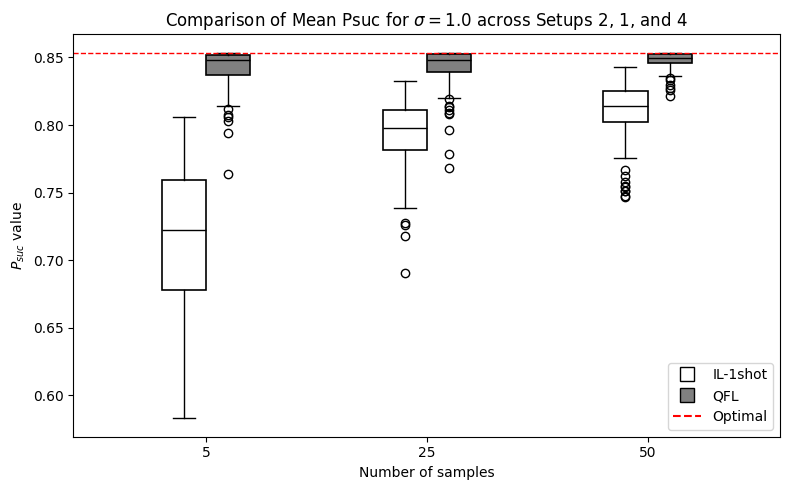

In [38]:
import matplotlib.pyplot as plt

# Example placeholders — replace with your actual arrays
# For σ = 1.0, each setup has data for both 1s and QFL
mean_Psucs_1s_setup2 = all_mean_Psucs_1s_s1_setup2.flatten()
mean_Psucs_1s_setup1 = all_mean_Psucs_1s_s1_setup1.flatten()
mean_Psucs_1s_setup4 = all_mean_Psucs_1s_s1_setup4.flatten()

QFL_setup2 = QFL_Psucs_s1_setup2.flatten()
QFL_setup1 = QFL_Psucs_s1_setup1.flatten()
QFL_setup4 = QFL_Psucs_s1_setup4.flatten()

# Organize data per setup
data_groups = [
    [mean_Psucs_1s_setup2, QFL_setup2],
    [mean_Psucs_1s_setup1, QFL_setup1],
    [mean_Psucs_1s_setup4, QFL_setup4]
]

# Labels for setups
setup_labels = ["5", "25", "50"]

# Position setup
num_groups = len(data_groups)
group_centers = list(range(1, num_groups + 1))
width = 0.2
offsets = [-width/2, width/2]  # two boxes per group (1s, QFL)

plt.figure(figsize=(8, 5))

# Fill colors (grayscale)
fills = ['white', 'gray']
edge_color = 'black'

# Plot each setup
for i, group_data in enumerate(data_groups):
    positions = [group_centers[i] + o for o in offsets]
    for pos, data, fill in zip(positions, group_data, fills):
        plt.boxplot(data, positions=[pos], widths=width, patch_artist=True,
                    boxprops=dict(facecolor=fill, color=edge_color, linewidth=1.2),
                    medianprops=dict(color='black'))

# Reference line (optional)
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1, label="Reference (0.8536)")

# X-axis
plt.xticks(group_centers, setup_labels)
plt.xlabel("Number of samples")
plt.ylabel("$P_{suc}$ value")
plt.title(r"Comparison of Mean Psuc for $\sigma=1.0$ across Setups 2, 1, and 4")

# Legend — only methods + reference
handles = [
    plt.Line2D([], [], color='black', marker='s', markerfacecolor='white', markersize=10,
               linestyle='None', label='IL-1shot'),
    plt.Line2D([], [], color='black', marker='s', markerfacecolor='gray', markersize=10,
               linestyle='None', label='QFL'),
    plt.Line2D([], [], color='red', linestyle='--', label='Optimal')
]
plt.legend(handles=handles, loc='best')

plt.tight_layout()
plt.show()


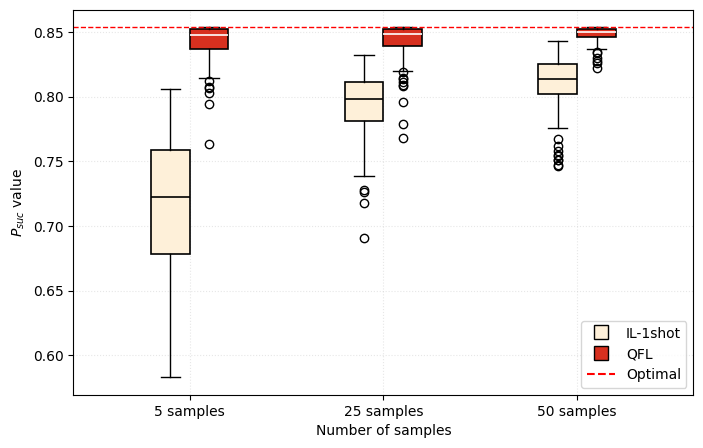

In [39]:
import matplotlib.pyplot as plt

# Example placeholders — replace with your actual arrays
mean_Psucs_1s_setup2 = all_mean_Psucs_1s_s1_setup2.flatten()
mean_Psucs_1s_setup1 = all_mean_Psucs_1s_s1_setup1.flatten()
mean_Psucs_1s_setup4 = all_mean_Psucs_1s_s1_setup4.flatten()

QFL_setup2 = QFL_Psucs_s1_setup2.flatten()
QFL_setup1 = QFL_Psucs_s1_setup1.flatten()
QFL_setup4 = QFL_Psucs_s1_setup4.flatten()

# --- Organize data per setup ---
data_groups = [
    [mean_Psucs_1s_setup2, QFL_setup2],
    [mean_Psucs_1s_setup1, QFL_setup1],
    [mean_Psucs_1s_setup4, QFL_setup4]
]

# --- Labels for setups ---
setup_labels = ["5 samples", "25 samples", "50 samples"]

# --- Position setup ---
num_groups = len(data_groups)
group_centers = list(range(1, num_groups + 1))
width = 0.2
offsets = [-width/2, width/2]  # two boxes per group (1s, QFL)

plt.figure(figsize=(8, 5))

# --- Fill colors ---
fills = ['#fef0d9', '#d7301f']
edge_color = 'black'

# --- Plot each setup ---
for i, group_data in enumerate(data_groups):
    positions = [group_centers[i] + o for o in offsets]
    for pos, data, fill in zip(positions, group_data, fills):
        plt.boxplot(
            data, positions=[pos], widths=width, patch_artist=True,
            boxprops=dict(facecolor=fill, color=edge_color, linewidth=1.2),
            medianprops=dict(
                color='white' if fill == '#d7301f' else 'black', linewidth=1.2
            )
        )

# --- Reference line ---
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1, label="Reference (0.8536)")

# --- X-axis ---
plt.xticks(group_centers, setup_labels)
plt.xlabel("Number of samples")
plt.ylabel("$P_{suc}$ value")
# plt.title(r"Comparison of Mean Psuc for $\sigma=1.0$ across Setups 2, 1, and 4")

# --- Legend ---
handles = [
    plt.Line2D([], [], color='black', marker='s', markerfacecolor='#fef0d9',
               markersize=10, linestyle='None', label='IL-1shot'),
    plt.Line2D([], [], color='black', marker='s', markerfacecolor='#d7301f',
               markersize=10, linestyle='None', label='QFL'),
    plt.Line2D([], [], color='red', linestyle='--', label='Optimal')
]
plt.legend(handles=handles, loc='best')

# --- Style tweaks ---
plt.grid(True, linestyle=':', alpha=0.3)
plt.savefig("sigma1_setups321.png", dpi=600, bbox_inches="tight")
# plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave room on the right for the legend
plt.show()

In [40]:
print(np.mean(QFL_setup2),
      np.mean(QFL_setup1),
      np.mean(QFL_setup4),    
)

0.8411930000000001 0.8422340000000001 0.8478699999999999


## Client-increase plot

In [41]:
sigma_range = (1.0, 1.0)

In [42]:
n_shots = 1

In [43]:
num_samples = 5

### IL

#### Setup 3 (5 samples, 10 clients)

In [44]:
num_clients = 10

In [45]:
opt_lr_1s_s1_setup3 = 0.60

In [46]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s1_setup3]
seeds = np.arange(0, 100)

In [47]:
all_mean_Psucs_1s_s1_setup3, all_min_Psucs_1s_s1_setup3 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.6]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### Setup 4 (5 samples, 25 clients)

In [48]:
num_clients = 25

In [49]:
opt_lr_1s_s1_setup4 = 0.61

In [50]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s1_setup4]
seeds = np.arange(0, 100)

In [51]:
all_mean_Psucs_1s_s1_setup4, all_min_Psucs_1s_s1_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.61]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### Setup 5 (5 samples, 50 clients)

In [52]:
num_clients = 50

In [53]:
opt_lr_1s_s1_setup5 = 0.57

In [54]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s1_setup5]
seeds = np.arange(0, 100)

In [55]:
all_mean_Psucs_1s_s1_setup5, all_min_Psucs_1s_s1_setup5 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.57]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### QFL

#### Setup 3 (5 samples, 10 clients)

In [56]:
num_clients = 10

In [57]:
opt_lr_qfl_s1_setup2 = 0.62

In [58]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [opt_lr_qfl_s1_setup2]
seeds = np.arange(0, 100)

n_shots = 1

In [59]:
QFL_Psucs_s1_setup2 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.62]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### Setup 4 (5 samples, 25 clients)

In [60]:
num_clients = 25

In [61]:
opt_lr_qfl_s1_setup3 = 0.60

In [62]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [opt_lr_qfl_s1_setup3]
seeds = np.arange(0, 100)

n_shots = 1

In [63]:
QFL_Psucs_s1_setup3 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.6]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### Setup 5 (5 samples, 50 clients)

In [64]:
num_clients = 50

In [65]:
opt_lr_qfl_s1_setup32 = 0.60

In [66]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [opt_lr_qfl_s1_setup32]
seeds = np.arange(0, 100)

n_shots = 1

In [67]:
QFL_Psucs_s1_setup32 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 5
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.6]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Plots

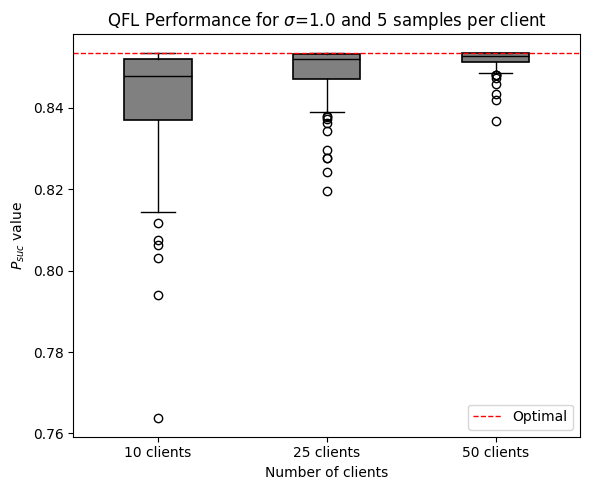

In [68]:
import matplotlib.pyplot as plt

# Example placeholders — replace with your actual arrays
QFL_clients_low = QFL_Psucs_s1_setup2.flatten()
QFL_clients_medium = QFL_Psucs_s1_setup3.flatten()
QFL_clients_high = QFL_Psucs_s1_setup32.flatten() # e.g. 100 clients

# Group data
data = [QFL_clients_low, QFL_clients_medium, QFL_clients_high]
labels = ["10 clients", "25 clients", "50 clients"]

# Plot
plt.figure(figsize=(6, 5))

# Boxplot style
plt.boxplot(data, patch_artist=True, widths=0.4,
            boxprops=dict(facecolor='gray', color='black', linewidth=1.2),
            medianprops=dict(color='black'))

# Reference line (optional)
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1, label="Optimal")

# Axis labels and title
plt.xticks([1, 2, 3], labels)
plt.xlabel("Number of clients")
plt.ylabel("$P_{suc}$ value")
plt.title(fr"QFL Performance for $\sigma$={sigma_range[0]} and {num_samples} samples per client")

# Legend (only reference line)
plt.legend(loc='best')

plt.tight_layout()
plt.show()


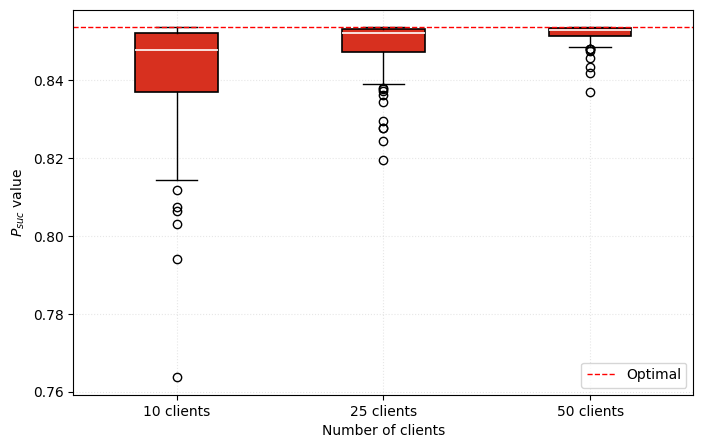

In [69]:
import matplotlib.pyplot as plt

# Example placeholders — replace with your actual arrays
QFL_clients_low = QFL_Psucs_s1_setup2.flatten()
QFL_clients_medium = QFL_Psucs_s1_setup3.flatten()
QFL_clients_high = QFL_Psucs_s1_setup32.flatten() # e.g. 100 clients

# Group data
data = [QFL_clients_low, QFL_clients_medium, QFL_clients_high]
labels = ["10 clients", "25 clients", "50 clients"]

# Plot
plt.figure(figsize=(8, 5))

# Boxplot style — all boxes deep red
box_color = "#d7301f"
plt.boxplot(
    data, patch_artist=True, widths=0.4,
    boxprops=dict(facecolor=box_color, color='black', linewidth=1.2),
    medianprops=dict(color='white', linewidth=1.2)  # white median for visibility
)

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1, label="Optimal")

# Axis labels and title
plt.xticks([1, 2, 3], labels)
plt.xlabel("Number of clients")
plt.ylabel("$P_{suc}$ value")
# plt.title(fr"QFL Performance for $\sigma$={sigma_range[0]} and {num_samples} samples per client")

# Legend (only reference line)
plt.legend(loc='best')

# plt.tight_layout()
plt.grid(True, linestyle=':', alpha=0.3)
plt.savefig("sigma1_setups345.png", dpi=600, bbox_inches="tight")
plt.show()

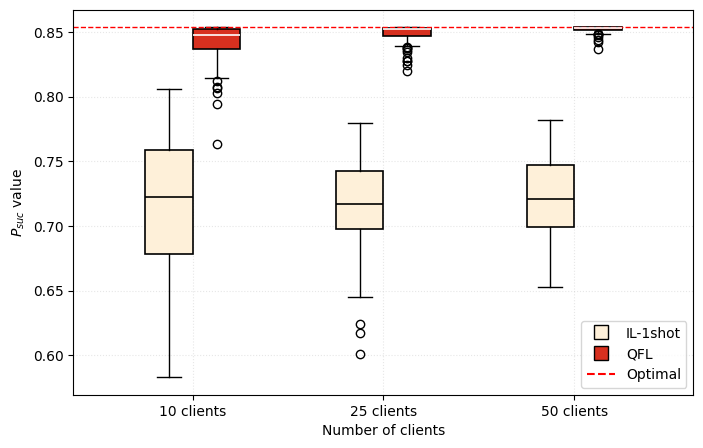

In [70]:
import matplotlib.pyplot as plt

# --- Data (replace placeholders with your actual IL arrays) ---
IL_clients_low = all_mean_Psucs_1s_s1_setup3.flatten()
IL_clients_medium = all_mean_Psucs_1s_s1_setup4.flatten()
IL_clients_high = all_mean_Psucs_1s_s1_setup5.flatten()

QFL_clients_low = QFL_Psucs_s1_setup2.flatten()
QFL_clients_medium = QFL_Psucs_s1_setup3.flatten()
QFL_clients_high = QFL_Psucs_s1_setup32.flatten()

# --- Organize per group ---
data_groups = [
    [IL_clients_low, QFL_clients_low],
    [IL_clients_medium, QFL_clients_medium],
    [IL_clients_high, QFL_clients_high]
]

group_labels = ["10 clients", "25 clients", "50 clients"]

# --- Positioning ---
num_groups = len(data_groups)
group_centers = list(range(1, num_groups + 1))
width = 0.25
offsets = [-width/2, width/2]  # IL, QFL

# --- Colors ---
fills = ['#fef0d9', '#d7301f']
edge_color = 'black'

plt.figure(figsize=(8, 5))

# --- Plot ---
for i, group_data in enumerate(data_groups):
    positions = [group_centers[i] + o for o in offsets]
    for pos, data, fill in zip(positions, group_data, fills):
        plt.boxplot(
            data,
            positions=[pos],
            widths=width,
            patch_artist=True,
            boxprops=dict(facecolor=fill, color=edge_color, linewidth=1.2),
            medianprops=dict(
                color='white' if fill == '#d7301f' else 'black', linewidth=1.2
            )
        )

# --- Reference line ---
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)

# --- Axes ---
plt.xticks(group_centers, group_labels)
plt.xlabel("Number of clients")
plt.ylabel("$P_{suc}$ value")
# plt.title(fr"IL vs QFL Performance for $\sigma$={sigma_range[0]}")

# --- Legend ---
handles = [
    plt.Line2D([], [], color='black', marker='s', markerfacecolor='#fef0d9',
               markersize=10, linestyle='None', label='IL-1shot'),
    plt.Line2D([], [], color='black', marker='s', markerfacecolor='#d7301f',
               markersize=10, linestyle='None', label='QFL'),
    plt.Line2D([], [], color='red', linestyle='--', label='Optimal')
]
plt.legend(handles=handles, loc='best')

# --- Style ---
plt.grid(True, linestyle=':', alpha=0.3)
# plt.tight_layout()
plt.savefig("sigma1_setups345.png", dpi=600, bbox_inches="tight")
plt.show()

# Noise increasing plot (Setup 4)

## Setup 4 (5 samples, 25 clients)

In [71]:
n_shots = 1

In [72]:
num_samples = 5

In [73]:
num_clients = 25

### Noiseless

In [74]:
#### IL

In [75]:
sigma_range = (0.0, 0.0)

In [76]:
# SETUP PARAMETER

lr_values = [0.63]
seeds = np.arange(0, 100)

In [77]:
all_mean_Psucs_1s_s0_setup4, all_min_Psucs_1s_s0_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.63]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [78]:
sigma_range = (4.0, 4.0)

In [79]:
# SETUP PARAMETER

lr_values = [0.64]
seeds = np.arange(0, 100)

In [80]:
all_mean_Psucs_1s_s4_setup4, all_min_Psucs_1s_s4_setup4 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.64]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [81]:
#### QFL

In [82]:
sigma_range = (0.0, 0.0)

In [83]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.62]
seeds = np.arange(0, 100)

n_shots = 1

In [84]:
QFL_Psucs_s0_setup4 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.62]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [85]:
sigma_range = (4.0, 4.0)

In [86]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.59]
seeds = np.arange(0, 100)

n_shots = 1

In [87]:
QFL_Psucs_s4_setup4 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.59]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Noisy

In [88]:
# ----------- Quantum circuit builder -----------
def build_circuit_test(x_input, theta):
    circuit = Circuit(1, density_matrix=True)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default

    # # DEPOLARIZING NOISE TO INPUT STATE
    # circuit.add(gates.DepolarizingChannel(0, 0.5))
    
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel_test(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
                
        circuit = build_circuit_test(x_input, self.theta.item())

        # noise = NoiseModel()
        # noise.add(DepolarizingError(0.5), gates.RY)   # <-- add once, targets all RY instances
        # # produce a noisy circuit (NoiseModel.apply inserts the noise channels)
        # noisy_circuit = noise.apply(circuit)
        
        return circuit

In [89]:
def repeat_setup_noise(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - lr: {lr_values}")

    all_mean_Psucs = []
    all_min_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        mean_Psucs = []
        min_Psucs = []
        
        for lr in lr_values:
            Psucs = []
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            for client in clients:
                client.local_train(client.num_samples, lr=lr)
                client_test = Client(None, None, vqc_class=QuantumModel_test)
                client_test.set_theta(client.get_theta())
                client_psuc = np.round(compute_Psuccess(client_test), 4)
                Psucs.append(client_psuc)
            
            mean_Psucs.append(np.mean(Psucs))
            min_Psucs.append(np.min(Psucs))
        
        all_mean_Psucs.append(mean_Psucs)
        all_min_Psucs.append(min_Psucs)

    return np.array(all_mean_Psucs), np.array(all_min_Psucs) 

In [90]:
def repeat_ECAI_QFL_setup_noise(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, 
                          num_rounds, local_batch_size, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - Number of Rounds: {num_rounds}")
    print(f" - Local Batch: {local_batch_size}")
    print(f" - lr: {lr_values}")
    
    QFL_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        QFL_Psucs_aux = []
        
        for lr in lr_values:
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            global_weights_evolution = run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=lr, 
                                                                   local_batch_size=local_batch_size)
            QFL_client = Client(None, None, vqc_class=QuantumModel_test)
            QFL_client.set_theta(global_weights_evolution[-1])
            
            global_psuc = np.round(compute_Psuccess(QFL_client), 4)
            # for client in clients:
            #     client.local_train(client.num_samples, lr=lr)
            #     client_psuc = np.round(compute_Psuccess(client), 4)
            #     Psucs.append(client_psuc)
            
            QFL_Psucs_aux.append(global_psuc)
        
        QFL_Psucs.append(QFL_Psucs_aux)

    return np.array(QFL_Psucs) 

#### depolarizing noise 0.1

In [91]:
# ----------- Quantum circuit builder -----------
def build_circuit(x_input, theta):
    circuit = Circuit(1, density_matrix=True)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default

    # DEPOLARIZING NOISE TO INPUT STATE
    circuit.add(gates.DepolarizingChannel(0, 0.1))
    
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Parameter-shift gradient estimator -----------
def parameter_shift_grad(x_input, theta, label, shift=np.pi/2, n_shots=1):
    theta_plus = theta + shift
    theta_minus = theta - shift

    # Evaluate circuit at shifted parameters
    result_plus = build_circuit(x_input, theta_plus)(nshots=n_shots)
    result_minus = build_circuit(x_input, theta_minus)(nshots=n_shots)


    #bit_plus = int(result_plus.samples()[0, 0])
    bit_plus = np.mean(result_plus.samples())
    #print("Number of Shots:", n_shots)
    #bit_minus = int(result_minus.samples()[0, 0])
    bit_minus = np.mean(result_minus.samples())

    pred_plus = bit_plus
    pred_minus = bit_minus

    """# Loss = 0 if prediction == label, 1 otherwise
    loss_plus = 0.0 if pred_plus == label else 1.0
    loss_minus = 0.0 if pred_minus == label else 1.0"""
    # Clip to avoid log(0)
    eps = 1e-6
    p_plus = np.clip(pred_plus, eps, 1 - eps)
    p_minus = np.clip(pred_minus, eps, 1 - eps)

    # BCE loss
    loss_plus = -label * np.log(p_plus) - (1 - label) * np.log(1 - p_plus)
    loss_minus = -label * np.log(p_minus) - (1 - label) * np.log(1 - p_minus)

    grad = 0.5 * (loss_plus - loss_minus)
    return grad


# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
                
        circuit = build_circuit(x_input, self.theta.item())

        # noise = NoiseModel()
        # noise.add(DepolarizingError(0.5), gates.RY)   # <-- add once, targets all RY instances
        # # produce a noisy circuit (NoiseModel.apply inserts the noise channels)
        # noisy_circuit = noise.apply(circuit)
        
        return circuit

In [92]:
sigma_range = (0.0, 0.0)

In [93]:
# SETUP PARAMETER

lr_values = [0.70]
seeds = np.arange(0, 100)

In [94]:
all_mean_Psucs_1s_s0_dn01_setup4, all_min_Psucs_1s_s0_dn01_setup4 = repeat_setup_noise(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.7]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [95]:
sigma_range = (4.0, 4.0)

In [96]:
# SETUP PARAMETER

lr_values = [0.69]
seeds = np.arange(0, 100)

In [97]:
all_mean_Psucs_1s_s4_dn01_setup4, all_min_Psucs_1s_s4_dn01_setup4 = repeat_setup_noise(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.69]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [98]:
sigma_range = (0.0, 0.0)

In [99]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.61]
seeds = np.arange(0, 100)

n_shots = 1

In [100]:
QFL_Psucs_s0_dn01_setup4 = repeat_ECAI_QFL_setup_noise(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.61]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [101]:
sigma_range = (4.0, 4.0)

In [102]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.68]
seeds = np.arange(0, 100)

n_shots = 1

In [103]:
QFL_Psucs_s4_dn01_setup4 = repeat_ECAI_QFL_setup_noise(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.68]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### depolarizing noise 0.2

In [104]:
# ----------- Quantum circuit builder -----------
def build_circuit(x_input, theta):
    circuit = Circuit(1, density_matrix=True)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default

    # DEPOLARIZING NOISE TO INPUT STATE
    circuit.add(gates.DepolarizingChannel(0, 0.2))
    
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Parameter-shift gradient estimator -----------
def parameter_shift_grad(x_input, theta, label, shift=np.pi/2, n_shots=1):
    theta_plus = theta + shift
    theta_minus = theta - shift

    # Evaluate circuit at shifted parameters
    result_plus = build_circuit(x_input, theta_plus)(nshots=n_shots)
    result_minus = build_circuit(x_input, theta_minus)(nshots=n_shots)


    #bit_plus = int(result_plus.samples()[0, 0])
    bit_plus = np.mean(result_plus.samples())
    #print("Number of Shots:", n_shots)
    #bit_minus = int(result_minus.samples()[0, 0])
    bit_minus = np.mean(result_minus.samples())

    pred_plus = bit_plus
    pred_minus = bit_minus

    """# Loss = 0 if prediction == label, 1 otherwise
    loss_plus = 0.0 if pred_plus == label else 1.0
    loss_minus = 0.0 if pred_minus == label else 1.0"""
    # Clip to avoid log(0)
    eps = 1e-6
    p_plus = np.clip(pred_plus, eps, 1 - eps)
    p_minus = np.clip(pred_minus, eps, 1 - eps)

    # BCE loss
    loss_plus = -label * np.log(p_plus) - (1 - label) * np.log(1 - p_plus)
    loss_minus = -label * np.log(p_minus) - (1 - label) * np.log(1 - p_minus)

    grad = 0.5 * (loss_plus - loss_minus)
    return grad


# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
                
        circuit = build_circuit(x_input, self.theta.item())

        # noise = NoiseModel()
        # noise.add(DepolarizingError(0.5), gates.RY)   # <-- add once, targets all RY instances
        # # produce a noisy circuit (NoiseModel.apply inserts the noise channels)
        # noisy_circuit = noise.apply(circuit)
        
        return circuit

In [105]:
sigma_range = (0.0, 0.0)

In [106]:
# SETUP PARAMETER

lr_values = [0.67]
seeds = np.arange(0, 100)

In [107]:
all_mean_Psucs_1s_s0_dn02_setup4, all_min_Psucs_1s_s0_dn02_setup4 = repeat_setup_noise(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.67]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [108]:
sigma_range = (4.0, 4.0)

In [109]:
# SETUP PARAMETER

lr_values = [0.58]
seeds = np.arange(0, 100)

In [110]:
all_mean_Psucs_1s_s4_dn02_setup4, all_min_Psucs_1s_s4_dn02_setup4 = repeat_setup_noise(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.58]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [111]:
sigma_range = (0.0, 0.0)

In [112]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.63]
seeds = np.arange(0, 100)

n_shots = 1

In [113]:
QFL_Psucs_s0_dn02_setup4 = repeat_ECAI_QFL_setup_noise(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.63]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [114]:
sigma_range = (4.0, 4.0)

In [115]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.72]
seeds = np.arange(0, 100)

n_shots = 1

In [116]:
QFL_Psucs_s4_dn02_setup4 = repeat_ECAI_QFL_setup_noise(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.72]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### depolarizing noise 0.3

In [117]:
# ----------- Quantum circuit builder -----------
def build_circuit(x_input, theta):
    circuit = Circuit(1, density_matrix=True)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default

    # DEPOLARIZING NOISE TO INPUT STATE
    circuit.add(gates.DepolarizingChannel(0, 0.3))
    
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Parameter-shift gradient estimator -----------
def parameter_shift_grad(x_input, theta, label, shift=np.pi/2, n_shots=1):
    theta_plus = theta + shift
    theta_minus = theta - shift

    # Evaluate circuit at shifted parameters
    result_plus = build_circuit(x_input, theta_plus)(nshots=n_shots)
    result_minus = build_circuit(x_input, theta_minus)(nshots=n_shots)


    #bit_plus = int(result_plus.samples()[0, 0])
    bit_plus = np.mean(result_plus.samples())
    #print("Number of Shots:", n_shots)
    #bit_minus = int(result_minus.samples()[0, 0])
    bit_minus = np.mean(result_minus.samples())

    pred_plus = bit_plus
    pred_minus = bit_minus

    """# Loss = 0 if prediction == label, 1 otherwise
    loss_plus = 0.0 if pred_plus == label else 1.0
    loss_minus = 0.0 if pred_minus == label else 1.0"""
    # Clip to avoid log(0)
    eps = 1e-6
    p_plus = np.clip(pred_plus, eps, 1 - eps)
    p_minus = np.clip(pred_minus, eps, 1 - eps)

    # BCE loss
    loss_plus = -label * np.log(p_plus) - (1 - label) * np.log(1 - p_plus)
    loss_minus = -label * np.log(p_minus) - (1 - label) * np.log(1 - p_minus)

    grad = 0.5 * (loss_plus - loss_minus)
    return grad


# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
                
        circuit = build_circuit(x_input, self.theta.item())

        # noise = NoiseModel()
        # noise.add(DepolarizingError(0.5), gates.RY)   # <-- add once, targets all RY instances
        # # produce a noisy circuit (NoiseModel.apply inserts the noise channels)
        # noisy_circuit = noise.apply(circuit)
        
        return circuit

In [118]:
sigma_range = (0.0, 0.0)

In [119]:
# SETUP PARAMETER

lr_values = [0.74]
seeds = np.arange(0, 100)

In [120]:
all_mean_Psucs_1s_s0_dn03_setup4, all_min_Psucs_1s_s0_dn03_setup4 = repeat_setup_noise(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.74]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [121]:
sigma_range = (4.0, 4.0)

In [122]:
# SETUP PARAMETER

lr_values = [0.70]
seeds = np.arange(0, 100)

In [123]:
all_mean_Psucs_1s_s4_dn03_setup4, all_min_Psucs_1s_s4_dn03_setup4 = repeat_setup_noise(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.7]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [124]:
sigma_range = (0.0, 0.0)

In [125]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.63]
seeds = np.arange(0, 100)

n_shots = 1

In [126]:
QFL_Psucs_s0_dn03_setup4 = repeat_ECAI_QFL_setup_noise(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.63]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [127]:
sigma_range = (4.0, 4.0)

In [128]:
# SETUP PARAMETER
num_rounds = 1
local_batch_size = 5

lr_values = [0.61]
seeds = np.arange(0, 100)

n_shots = 1

In [129]:
QFL_Psucs_s4_dn03_setup4 = repeat_ECAI_QFL_setup_noise(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 5
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 1
 - Local Batch: 5
 - lr: [0.61]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### Comparisons

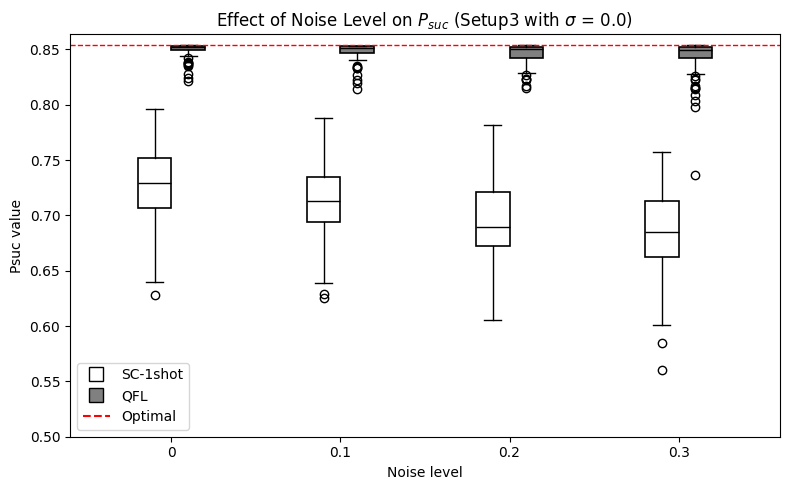

In [130]:
import matplotlib.pyplot as plt

# --- Replace with your actual arrays ---
# Single-client results
Psucs_1s_0 = all_mean_Psucs_1s_s0_setup4.flatten()
Psucs_1s_01 = all_mean_Psucs_1s_s0_dn01_setup4.flatten()
Psucs_1s_02 = all_mean_Psucs_1s_s0_dn02_setup4.flatten()
Psucs_1s_03 = all_mean_Psucs_1s_s0_dn03_setup4.flatten()

# QFL results
Psucs_QFL_0 = QFL_Psucs_s0_setup4.flatten()
Psucs_QFL_01 = QFL_Psucs_s0_dn01_setup4.flatten()
Psucs_QFL_02 = QFL_Psucs_s0_dn02_setup4.flatten()
Psucs_QFL_03 = QFL_Psucs_s0_dn03_setup4.flatten()

# --- Organize data ---
data_1s = [Psucs_1s_0, Psucs_1s_01, Psucs_1s_02, Psucs_1s_03]
data_QFL = [Psucs_QFL_0, Psucs_QFL_01, Psucs_QFL_02, Psucs_QFL_03]
noise_labels = ["0", "0.1", "0.2", "0.3"]

# --- Define positions ---
group_centers = list(range(1, len(noise_labels) + 1))
width = 0.2
offsets = [-width/2, width/2]
positions_1s = [c + offsets[0] for c in group_centers]
positions_QFL = [c + offsets[1] for c in group_centers]

plt.figure(figsize=(8, 5))

# --- Colors (grayscale) ---
fills = ['white', 'gray']
edge_color = 'black'

# --- Plot single-client boxes ---
for pos, data in zip(positions_1s, data_1s):
    plt.boxplot(data, positions=[pos], widths=width, patch_artist=True,
                boxprops=dict(facecolor=fills[0], color=edge_color, linewidth=1.2),
                medianprops=dict(color='black'))

# --- Plot QFL boxes ---
for pos, data in zip(positions_QFL, data_QFL):
    plt.boxplot(data, positions=[pos], widths=width, patch_artist=True,
                boxprops=dict(facecolor=fills[1], color=edge_color, linewidth=1.2),
                medianprops=dict(color='black'))

# --- Reference line (optional) ---
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1, label="Reference (0.8536)")

# --- X-axis and labels ---
plt.xticks(group_centers, noise_labels)
plt.xlabel("Noise level")
plt.ylabel("Psuc value")
plt.title(r"Effect of Noise Level on $P_{suc}$ (Setup3 with $\sigma$ = 0.0)")

# --- Legend ---
handles = [
    plt.Line2D([], [], color='black', marker='s', markerfacecolor='white', markersize=10,
               linestyle='None', label='SC-1shot'),
    plt.Line2D([], [], color='black', marker='s', markerfacecolor='gray', markersize=10,
               linestyle='None', label='QFL'),
    plt.Line2D([], [], color='red', linestyle='--', label='Optimal')
]
plt.legend(handles=handles, loc='best')
plt.ylim(0.50, 0.8536+0.01)
plt.tight_layout()
plt.show()


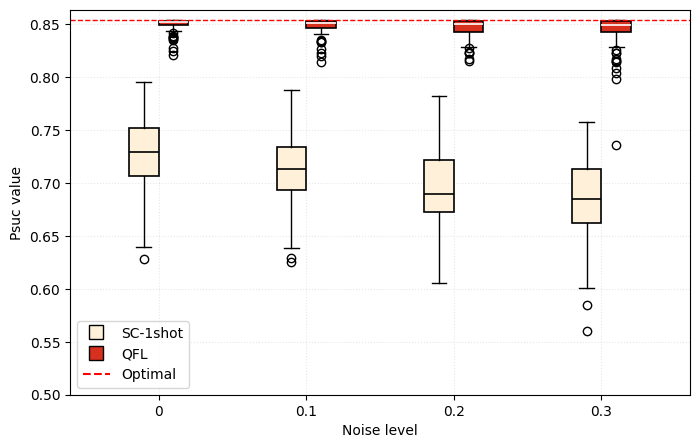

In [131]:
import matplotlib.pyplot as plt

# --- Replace with your actual arrays ---
# Single-client results
Psucs_1s_0 = all_mean_Psucs_1s_s0_setup4.flatten()
Psucs_1s_01 = all_mean_Psucs_1s_s0_dn01_setup4.flatten()
Psucs_1s_02 = all_mean_Psucs_1s_s0_dn02_setup4.flatten()
Psucs_1s_03 = all_mean_Psucs_1s_s0_dn03_setup4.flatten()

# QFL results
Psucs_QFL_0 = QFL_Psucs_s0_setup4.flatten()
Psucs_QFL_01 = QFL_Psucs_s0_dn01_setup4.flatten()
Psucs_QFL_02 = QFL_Psucs_s0_dn02_setup4.flatten()
Psucs_QFL_03 = QFL_Psucs_s0_dn03_setup4.flatten()

# --- Organize data ---
data_1s = [Psucs_1s_0, Psucs_1s_01, Psucs_1s_02, Psucs_1s_03]
data_QFL = [Psucs_QFL_0, Psucs_QFL_01, Psucs_QFL_02, Psucs_QFL_03]
noise_labels = ["0", "0.1", "0.2", "0.3"]

# --- Define positions ---
group_centers = list(range(1, len(noise_labels) + 1))
width = 0.2
offsets = [-width/2, width/2]
positions_1s = [c + offsets[0] for c in group_centers]
positions_QFL = [c + offsets[1] for c in group_centers]

plt.figure(figsize=(8, 5))

# --- Colors (warm palette) ---
color_1s = "#fef0d9"
color_qfl = "#d7301f"
edge_color = "black"

# --- Plot SC-1shot boxes ---
for pos, data in zip(positions_1s, data_1s):
    plt.boxplot(
        data, positions=[pos], widths=width, patch_artist=True,
        boxprops=dict(facecolor=color_1s, color=edge_color, linewidth=1.2),
        medianprops=dict(color='black', linewidth=1.2)
    )

# --- Plot QFL boxes ---
for pos, data in zip(positions_QFL, data_QFL):
    plt.boxplot(
        data, positions=[pos], widths=width, patch_artist=True,
        boxprops=dict(facecolor=color_qfl, color=edge_color, linewidth=1.2),
        medianprops=dict(color='white', linewidth=1.2)  # visible on red
    )

# --- Reference line ---
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1, label="Optimal")

# --- X-axis and labels ---
plt.xticks(group_centers, noise_labels)
plt.xlabel("Noise level")
plt.ylabel("Psuc value")
# plt.title(r"Effect of Noise Level on $P_{suc}$ (Setup3 with $\sigma$ = 0.0)")

# --- Legend ---
handles = [
    plt.Line2D([], [], color='black', marker='s',
               markerfacecolor=color_1s, markersize=10,
               linestyle='None', label='SC-1shot'),
    plt.Line2D([], [], color='black', marker='s',
               markerfacecolor=color_qfl, markersize=10,
               linestyle='None', label='QFL'),
    plt.Line2D([], [], color='red', linestyle='--', label='Optimal')
]
plt.legend(handles=handles, loc='best')

plt.ylim(0.50, 0.8536 + 0.01)
# plt.tight_layout()
plt.grid(True, linestyle=':', alpha=0.3)
plt.savefig("sigma0_setup4_noise.png", dpi=600, bbox_inches="tight")
plt.show()

In [132]:
print(np.mean(all_mean_Psucs_1s_s0_setup4),
     np.mean(all_mean_Psucs_1s_s0_dn01_setup4),
     np.mean(all_mean_Psucs_1s_s0_dn02_setup4),
     np.mean(all_mean_Psucs_1s_s0_dn03_setup4))

0.7259892000000001 0.7121239999999999 0.6946080400000002 0.6851535600000002


In [133]:
print(np.mean(QFL_Psucs_s0_setup4),
     np.mean(QFL_Psucs_s0_dn01_setup4),
     np.mean(QFL_Psucs_s0_dn02_setup4),
     np.mean(QFL_Psucs_s0_dn03_setup4))

0.84956 0.8482590000000001 0.8460630000000002 0.8434919999999999


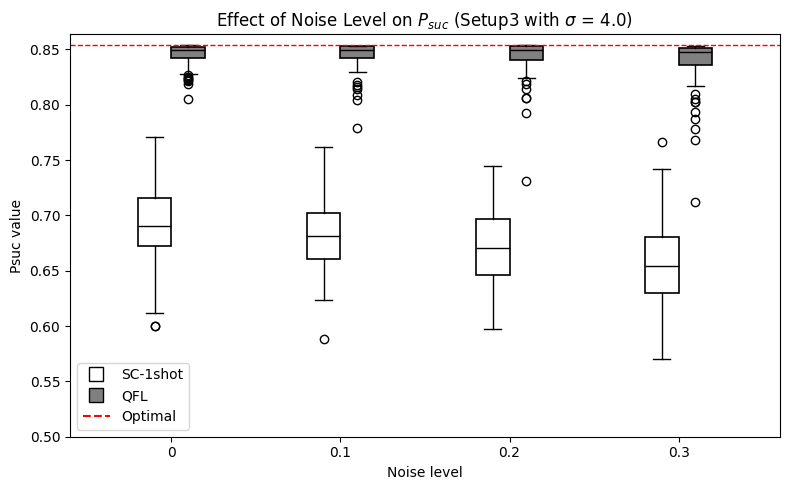

In [134]:
import matplotlib.pyplot as plt

# --- Replace with your actual arrays ---
# Single-client results
Psucs_1s_0 = all_mean_Psucs_1s_s4_setup4.flatten()
Psucs_1s_01 = all_mean_Psucs_1s_s4_dn01_setup4.flatten()
Psucs_1s_02 = all_mean_Psucs_1s_s4_dn02_setup4.flatten()
Psucs_1s_03 = all_mean_Psucs_1s_s4_dn03_setup4.flatten()

# QFL results
Psucs_QFL_0 = QFL_Psucs_s4_setup4.flatten()
Psucs_QFL_01 = QFL_Psucs_s4_dn01_setup4.flatten()
Psucs_QFL_02 = QFL_Psucs_s4_dn02_setup4.flatten()
Psucs_QFL_03 = QFL_Psucs_s4_dn03_setup4.flatten()

# --- Organize data ---
data_1s = [Psucs_1s_0, Psucs_1s_01, Psucs_1s_02, Psucs_1s_03]
data_QFL = [Psucs_QFL_0, Psucs_QFL_01, Psucs_QFL_02, Psucs_QFL_03]
noise_labels = ["0", "0.1", "0.2", "0.3"]

# --- Define positions ---
group_centers = list(range(1, len(noise_labels) + 1))
width = 0.2
offsets = [-width/2, width/2]
positions_1s = [c + offsets[0] for c in group_centers]
positions_QFL = [c + offsets[1] for c in group_centers]

plt.figure(figsize=(8, 5))

# --- Colors (grayscale) ---
fills = ['white', 'gray']
edge_color = 'black'

# --- Plot single-client boxes ---
for pos, data in zip(positions_1s, data_1s):
    plt.boxplot(data, positions=[pos], widths=width, patch_artist=True,
                boxprops=dict(facecolor=fills[0], color=edge_color, linewidth=1.2),
                medianprops=dict(color='black'))

# --- Plot QFL boxes ---
for pos, data in zip(positions_QFL, data_QFL):
    plt.boxplot(data, positions=[pos], widths=width, patch_artist=True,
                boxprops=dict(facecolor=fills[1], color=edge_color, linewidth=1.2),
                medianprops=dict(color='black'))

# --- Reference line (optional) ---
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1, label="Reference (0.8536)")

# --- X-axis and labels ---
plt.xticks(group_centers, noise_labels)
plt.xlabel("Noise level")
plt.ylabel("Psuc value")
plt.title(r"Effect of Noise Level on $P_{suc}$ (Setup3 with $\sigma$ = 4.0)")

# --- Legend ---
handles = [
    plt.Line2D([], [], color='black', marker='s', markerfacecolor='white', markersize=10,
               linestyle='None', label='SC-1shot'),
    plt.Line2D([], [], color='black', marker='s', markerfacecolor='gray', markersize=10,
               linestyle='None', label='QFL'),
    plt.Line2D([], [], color='red', linestyle='--', label='Optimal')
]
plt.legend(handles=handles, loc='best')
plt.ylim(0.50, 0.8536+0.01)
plt.tight_layout()
plt.show()


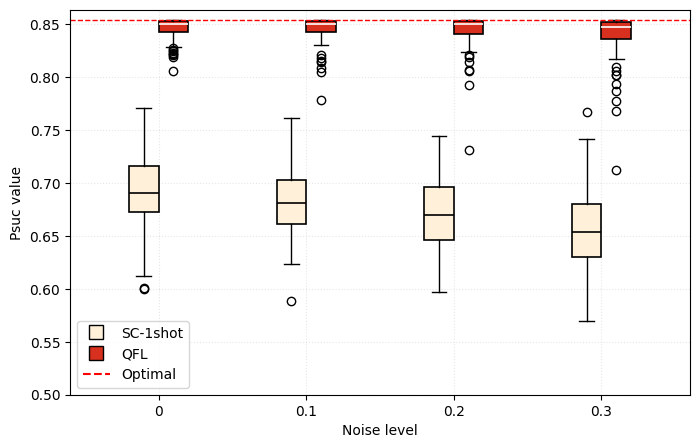

In [135]:
import matplotlib.pyplot as plt

# --- Replace with your actual arrays ---
# Single-client results
Psucs_1s_0 = all_mean_Psucs_1s_s4_setup4.flatten()
Psucs_1s_01 = all_mean_Psucs_1s_s4_dn01_setup4.flatten()
Psucs_1s_02 = all_mean_Psucs_1s_s4_dn02_setup4.flatten()
Psucs_1s_03 = all_mean_Psucs_1s_s4_dn03_setup4.flatten()

# QFL results
Psucs_QFL_0 = QFL_Psucs_s4_setup4.flatten()
Psucs_QFL_01 = QFL_Psucs_s4_dn01_setup4.flatten()
Psucs_QFL_02 = QFL_Psucs_s4_dn02_setup4.flatten()
Psucs_QFL_03 = QFL_Psucs_s4_dn03_setup4.flatten()

# --- Organize data ---
data_1s = [Psucs_1s_0, Psucs_1s_01, Psucs_1s_02, Psucs_1s_03]
data_QFL = [Psucs_QFL_0, Psucs_QFL_01, Psucs_QFL_02, Psucs_QFL_03]
noise_labels = ["0", "0.1", "0.2", "0.3"]

# --- Define positions ---
group_centers = list(range(1, len(noise_labels) + 1))
width = 0.2
offsets = [-width/2, width/2]
positions_1s = [c + offsets[0] for c in group_centers]
positions_QFL = [c + offsets[1] for c in group_centers]

plt.figure(figsize=(8, 5))

# --- Colors (warm palette) ---
color_1s = "#fef0d9"   # SC-1shot
color_qfl = "#d7301f"  # QFL
edge_color = "black"

# --- Plot single-client boxes ---
for pos, data in zip(positions_1s, data_1s):
    plt.boxplot(
        data, positions=[pos], widths=width, patch_artist=True,
        boxprops=dict(facecolor=color_1s, color=edge_color, linewidth=1.2),
        medianprops=dict(color='black', linewidth=1.2)
    )

# --- Plot QFL boxes ---
for pos, data in zip(positions_QFL, data_QFL):
    plt.boxplot(
        data, positions=[pos], widths=width, patch_artist=True,
        boxprops=dict(facecolor=color_qfl, color=edge_color, linewidth=1.2),
        medianprops=dict(color='white', linewidth=1.2)  # white for visibility
    )

# --- Reference line ---
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1, label="Optimal")

# --- X-axis and labels ---
plt.xticks(group_centers, noise_labels)
plt.xlabel("Noise level")
plt.ylabel("Psuc value")
# plt.title(r"Effect of Noise Level on $P_{suc}$ (Setup3 with $\sigma$ = 4.0)")

# --- Legend ---
handles = [
    plt.Line2D([], [], color='black', marker='s',
               markerfacecolor=color_1s, markersize=10,
               linestyle='None', label='SC-1shot'),
    plt.Line2D([], [], color='black', marker='s',
               markerfacecolor=color_qfl, markersize=10,
               linestyle='None', label='QFL'),
    plt.Line2D([], [], color='red', linestyle='--', label='Optimal')
]
plt.legend(handles=handles, loc='best')

plt.ylim(0.50, 0.8536 + 0.01)
# plt.tight_layout()
plt.grid(True, linestyle=':', alpha=0.3)
plt.savefig("sigma4_setup4_noise.png", dpi=600, bbox_inches="tight")
plt.show()


In [136]:
print(np.mean(all_mean_Psucs_1s_s4_setup4),
     np.mean(all_mean_Psucs_1s_s4_dn01_setup4),
     np.mean(all_mean_Psucs_1s_s4_dn02_setup4),
     np.mean(all_mean_Psucs_1s_s4_dn03_setup4))

0.6904619599999999 0.6819425999999998 0.67179136 0.6561779600000002


In [137]:
print(np.mean(QFL_Psucs_s4_setup4),
     np.mean(QFL_Psucs_s4_dn01_setup4),
     np.mean(QFL_Psucs_s4_dn02_setup4),
     np.mean(QFL_Psucs_s4_dn03_setup4))

0.8455670000000001 0.8449509999999999 0.8434829999999998 0.8398220000000001


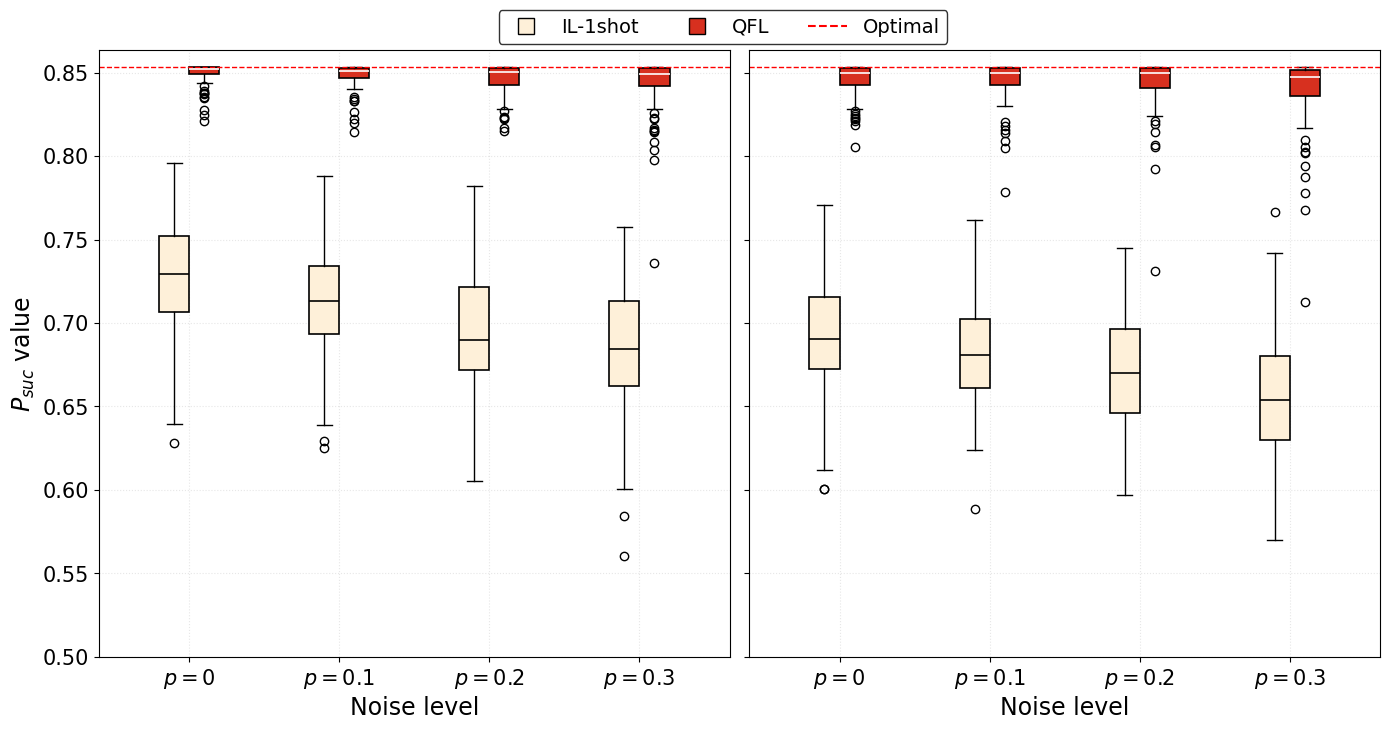

In [138]:
import matplotlib.pyplot as plt

# =====================================================
#  σ = 0.0 data
# =====================================================
Psucs_1s_0_s0  = all_mean_Psucs_1s_s0_setup4.flatten()
Psucs_1s_01_s0 = all_mean_Psucs_1s_s0_dn01_setup4.flatten()
Psucs_1s_02_s0 = all_mean_Psucs_1s_s0_dn02_setup4.flatten()
Psucs_1s_03_s0 = all_mean_Psucs_1s_s0_dn03_setup4.flatten()

Psucs_QFL_0_s0  = QFL_Psucs_s0_setup4.flatten()
Psucs_QFL_01_s0 = QFL_Psucs_s0_dn01_setup4.flatten()
Psucs_QFL_02_s0 = QFL_Psucs_s0_dn02_setup4.flatten()
Psucs_QFL_03_s0 = QFL_Psucs_s0_dn03_setup4.flatten()

data_1s_sigma0  = [Psucs_1s_0_s0, Psucs_1s_01_s0, Psucs_1s_02_s0, Psucs_1s_03_s0]
data_QFL_sigma0 = [Psucs_QFL_0_s0, Psucs_QFL_01_s0, Psucs_QFL_02_s0, Psucs_QFL_03_s0]

# =====================================================
#  σ = 4.0 data
# =====================================================
Psucs_1s_0_s4  = all_mean_Psucs_1s_s4_setup4.flatten()
Psucs_1s_01_s4 = all_mean_Psucs_1s_s4_dn01_setup4.flatten()
Psucs_1s_02_s4 = all_mean_Psucs_1s_s4_dn02_setup4.flatten()
Psucs_1s_03_s4 = all_mean_Psucs_1s_s4_dn03_setup4.flatten()

Psucs_QFL_0_s4  = QFL_Psucs_s4_setup4.flatten()
Psucs_QFL_01_s4 = QFL_Psucs_s4_dn01_setup4.flatten()
Psucs_QFL_02_s4 = QFL_Psucs_s4_dn02_setup4.flatten()
Psucs_QFL_03_s4 = QFL_Psucs_s4_dn03_setup4.flatten()

data_1s_sigma4  = [Psucs_1s_0_s4, Psucs_1s_01_s4, Psucs_1s_02_s4, Psucs_1s_03_s4]
data_QFL_sigma4 = [Psucs_QFL_0_s4, Psucs_QFL_01_s4, Psucs_QFL_02_s4, Psucs_QFL_03_s4]

# =====================================================
#  Shared settings
# =====================================================
color_1s  = "#fef0d9"
color_qfl = "#d7301f"
edge_color = "black"

noise_labels = ["$p=0$", "$p=0.1$", "$p=0.2$", "$p=0.3$"]
group_centers = list(range(1, len(noise_labels) + 1))
width = 0.2
offsets = [-width/2, width/2]
positions_1s  = [c + offsets[0] for c in group_centers]
positions_QFL = [c + offsets[1] for c in group_centers]

# =====================================================
#  Larger & taller figure with bigger tick labels
# =====================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# fontsize settings
title_fs = 17
label_fs = 17
tick_fs = 15
legend_fs = 14

# ----------------------------------------
# Function to plot one panel
# ----------------------------------------
def plot_panel(ax, data_1s, data_QFL, title):
    # SC-1shot
    for pos, data in zip(positions_1s, data_1s):
        ax.boxplot(
            data, positions=[pos], widths=width, patch_artist=True,
            boxprops=dict(facecolor=color_1s, color=edge_color, linewidth=1.2),
            medianprops=dict(color='black', linewidth=1.2)
        )

    # QFL
    for pos, data in zip(positions_QFL, data_QFL):
        ax.boxplot(
            data, positions=[pos], widths=width, patch_artist=True,
            boxprops=dict(facecolor=color_qfl, color=edge_color, linewidth=1.2),
            medianprops=dict(color='white', linewidth=1.2)
        )

    # Reference line
    ax.axhline(0.8536, color='red', linestyle='--', linewidth=1)

    # Axis formatting
    ax.set_xticks(group_centers)
    ax.set_xticklabels(noise_labels)
    ax.set_title(title, fontsize=title_fs)
    ax.set_xlabel("Noise level", fontsize=label_fs)
    ax.set_ylim(0.50, 0.8636)

    ax.tick_params(axis='x', labelsize=tick_fs)
    ax.tick_params(axis='y', labelsize=tick_fs)

    # Grid
    ax.grid(True, linestyle=':', alpha=0.3)

# ----------------------------------------
# Left: σ = 0.0
# ----------------------------------------
plot_panel(axes[0], data_1s_sigma0, data_QFL_sigma0,
           r"")
axes[0].set_ylabel("$P_{suc}$ value", fontsize=label_fs)

# ----------------------------------------
# Right: σ = 4.0
# ----------------------------------------
plot_panel(axes[1], data_1s_sigma4, data_QFL_sigma4,
           r"")

# ----------------------------------------
# Centered legend in a thin box **inside** the figure
# ----------------------------------------
handles = [
    plt.Line2D([], [], color=edge_color, marker='s', markerfacecolor=color_1s,
               markersize=12, linestyle='None', label='IL-1shot'),
    plt.Line2D([], [], color=edge_color, marker='s', markerfacecolor=color_qfl,
               markersize=12, linestyle='None', label='QFL'),
    plt.Line2D([], [], color='red', linestyle='--', label='Optimal'),
]

fig.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.52, 1.05),
    ncol=3,
    fontsize=legend_fs,
    frameon=True,
    facecolor='white',
    edgecolor='black',
    framealpha=0.8
)

plt.tight_layout()
plt.savefig("noise_comparison_setup4.png", dpi=600, bbox_inches="tight")
plt.show()

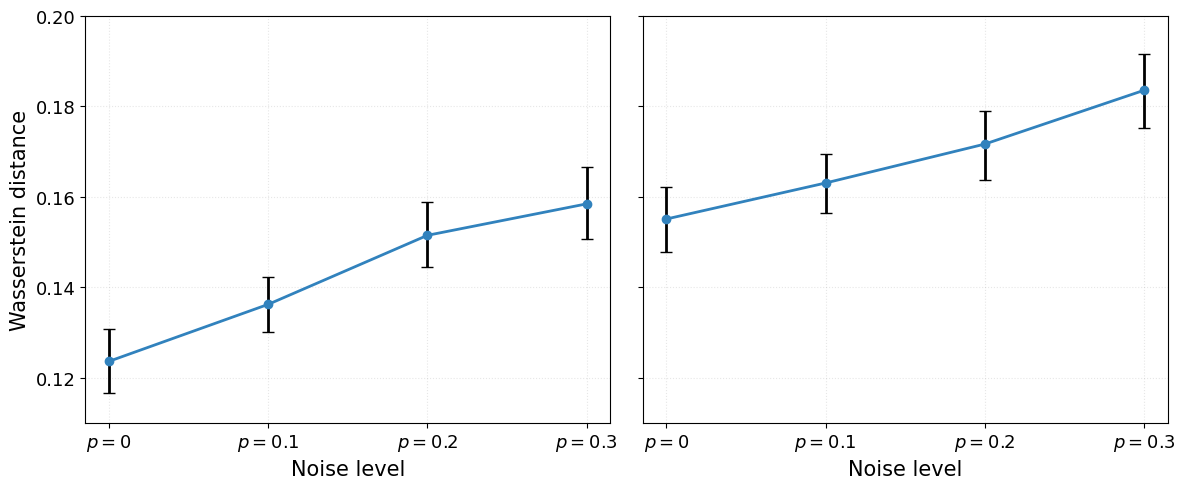

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# ======================
# 1) PREPARE DATA
# ======================

# ---- σ = 0 ----
SC_s0 = [
    all_mean_Psucs_1s_s0_setup4.flatten(),
    all_mean_Psucs_1s_s0_dn01_setup4.flatten(),
    all_mean_Psucs_1s_s0_dn02_setup4.flatten(),
    all_mean_Psucs_1s_s0_dn03_setup4.flatten()
]

QFL_s0 = [
    QFL_Psucs_s0_setup4.flatten(),
    QFL_Psucs_s0_dn01_setup4.flatten(),
    QFL_Psucs_s0_dn02_setup4.flatten(),
    QFL_Psucs_s0_dn03_setup4.flatten()
]

# ---- σ = 4 ----
SC_s4 = [
    all_mean_Psucs_1s_s4_setup4.flatten(),
    all_mean_Psucs_1s_s4_dn01_setup4.flatten(),
    all_mean_Psucs_1s_s4_dn02_setup4.flatten(),
    all_mean_Psucs_1s_s4_dn03_setup4.flatten()
]

QFL_s4 = [
    QFL_Psucs_s4_setup4.flatten(),
    QFL_Psucs_s4_dn01_setup4.flatten(),
    QFL_Psucs_s4_dn02_setup4.flatten(),
    QFL_Psucs_s4_dn03_setup4.flatten()
]

noise_levels = np.array([0.0, 0.1, 0.2, 0.3])


# ======================
# 2) FUNCTION: BOOTSTRAP CI
# ======================

def bootstrap_wasserstein(a, b, B=2000, ci=0.95):
    """Returns (mean, lower_CI, upper_CI) for Wasserstein distance."""
    nA, nB = len(a), len(b)
    boot_values = np.zeros(B)

    for i in range(B):
        a_s = np.random.choice(a, size=nA, replace=True)
        b_s = np.random.choice(b, size=nB, replace=True)
        boot_values[i] = wasserstein_distance(a_s, b_s)

    mean = np.mean(boot_values)
    lower = np.percentile(boot_values, (1 - ci) / 2 * 100)
    upper = np.percentile(boot_values, (1 + ci) / 2 * 100)

    return mean, lower, upper


# ======================
# 3) COMPUTE DISTANCES + CI FOR σ=0 and σ=4
# ======================

def compute_all_wasserstein(SC_list, QFL_list):
    means, lowers, uppers = [], [], []
    for sc, qfl in zip(SC_list, QFL_list):
        m, lo, up = bootstrap_wasserstein(sc, qfl)
        means.append(m)
        lowers.append(lo)
        uppers.append(up)
    return np.array(means), np.array(lowers), np.array(uppers)

mean0, low0, up0 = compute_all_wasserstein(SC_s0, QFL_s0)
mean4, low4, up4 = compute_all_wasserstein(SC_s4, QFL_s4)

# Error bars
err_low_0 = mean0 - low0
err_up_0 = up0 - mean0
err_low_4 = mean4 - low4
err_up_4 = up4 - mean4


# ======================
# 4) PLOT — TWO SUBPLOTS SIDE BY SIDE
# ======================

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Colors
color_line = "#3182bd"

# Common y-limits
ymin, ymax = 0.11, 0.20

# --- σ = 0 subplot ---
axes[0].errorbar(
    noise_levels, mean0,
    yerr=[err_low_0, err_up_0],
    fmt='o-', color=color_line, markersize=6,
    ecolor="black", capsize=4, linewidth=2
)
# axes[0].set_title(r"$\sigma = 0$")
axes[0].set_xlabel("Noise level", fontsize=15)
axes[0].set_ylabel("Wasserstein distance", fontsize=15)
axes[0].grid(True, linestyle=":", alpha=0.3)

xticks = noise_levels
xtick_labels = [r"$p=0$", r"$p=0.1$", r"$p=0.2$", r"$p=0.3$"]

axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xtick_labels)
axes[0].set_ylim(ymin, ymax)
axes[0].tick_params(axis='both', labelsize=13)

# --- σ = 4 subplot ---
axes[1].errorbar(
    noise_levels, mean4,
    yerr=[err_low_4, err_up_4],
    fmt='o-', color=color_line, markersize=6,
    ecolor="black", capsize=4, linewidth=2
)
# axes[1].set_title(r"$\sigma = 4$")
axes[1].set_xlabel("Noise level", fontsize=15)
axes[1].grid(True, linestyle=":", alpha=0.3)
xticks = noise_levels
xtick_labels = [r"$p=0$", r"$p=0.1$", r"$p=0.2$", r"$p=0.3$"]

axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xtick_labels)
axes[1].set_ylim(ymin, ymax)

# --- IMPORTANT FIX ---
axes[1].tick_params(axis='y', labelleft=False)   # hide numbers but keep ticks
axes[1].tick_params(axis='x', labelsize=13)

plt.tight_layout()
plt.savefig("noise_wasserstein_setup4.png", dpi=600, bbox_inches="tight")
plt.show()

# Noise increasing plot (all)

In [169]:
n_shots = 1

## Noiseless

### Setup 1

In [170]:
num_clients = 10
num_samples = 50

#### $\sigma = 0.0$

In [171]:
sigma_range = (0.0, 0.0)

##### IL

In [172]:
# SETUP PARAMETER

lr_values = [0.17]
seeds = np.arange(0, 100)

In [173]:
all_mean_Psucs_1s_s0_setup1_noise00, all_min_Psucs_1s_s0_setup1_noise00 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.17]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [174]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.13]
seeds = np.arange(0, 100)

In [175]:
QFL_Psucs_s0_5_10_setup1_noise00 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.13]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 0.5$

In [176]:
sigma_range = (0.5, 0.5)

##### IL

In [177]:
# SETUP PARAMETER

lr_values = [0.15]
seeds = np.arange(0, 100)

In [178]:
all_mean_Psucs_1s_s05_setup1_noise00, all_min_Psucs_1s_s05_setup1_noise00 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.15]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [179]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.10]
seeds = np.arange(0, 100)

In [180]:
QFL_Psucs_s05_5_10_setup1_noise00 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.1]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 1.0$

In [181]:
sigma_range = (1.0, 1.0)

##### IL

In [182]:
# SETUP PARAMETER

lr_values = [0.12]
seeds = np.arange(0, 100)

In [183]:
all_mean_Psucs_1s_s1_setup1_noise00, all_min_Psucs_1s_s1_setup1_noise00 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.12]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [184]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.11]
seeds = np.arange(0, 100)

In [185]:
QFL_Psucs_s1_5_10_setup1_noise00 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.11]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 4.0$

In [186]:
sigma_range = (4.0, 4.0)

##### IL

In [187]:
# SETUP PARAMETER

lr_values = [0.10]
seeds = np.arange(0, 100)

In [188]:
all_mean_Psucs_1s_s4_setup1_noise00, all_min_Psucs_1s_s4_setup1_noise00 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.1]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [189]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.15]
seeds = np.arange(0, 100)

In [190]:
QFL_Psucs_s4_5_10_setup1_noise00 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.15]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Setup 2

In [191]:
num_clients = 10
num_samples = 25

#### $\sigma = 0.0$

In [192]:
sigma_range = (0.0, 0.0)

##### IL

In [193]:
# SETUP PARAMETER

lr_values = [0.33]
seeds = np.arange(0, 100)

In [194]:
all_mean_Psucs_1s_s0_setup2_noise00, all_min_Psucs_1s_s0_setup2_noise00 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.33]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [195]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.27]
seeds = np.arange(0, 100)

In [196]:
QFL_Psucs_s0_5_5_setup2_noise00 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.27]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 0.5$

In [197]:
sigma_range = (0.5, 0.5)

##### IL

In [198]:
# SETUP PARAMETER

lr_values = [0.33]
seeds = np.arange(0, 100)

In [199]:
all_mean_Psucs_1s_s05_setup2_noise00, all_min_Psucs_1s_s05_setup2_noise00 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.33]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [200]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.21]
seeds = np.arange(0, 100)

In [201]:
QFL_Psucs_s05_5_5_setup2_noise00 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.21]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 1.0$

In [202]:
sigma_range = (1.0, 1.0)

##### IL

In [203]:
# SETUP PARAMETER

lr_values = [0.23]
seeds = np.arange(0, 100)

In [204]:
all_mean_Psucs_1s_s1_setup2_noise00, all_min_Psucs_1s_s1_setup2_noise00 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.23]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [205]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.21]
seeds = np.arange(0, 100)

In [206]:
QFL_Psucs_s1_5_5_setup2_noise00 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.21]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 4.0$

In [207]:
sigma_range = (4.0, 4.0)

##### IL

In [208]:
# SETUP PARAMETER

lr_values = [0.34]
seeds = np.arange(0, 100)

In [209]:
all_mean_Psucs_1s_s4_setup2_noise00, all_min_Psucs_1s_s4_setup2_noise00 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.34]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [210]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.24]
seeds = np.arange(0, 100)

In [211]:
QFL_Psucs_s4_5_5_setup2_noise00 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.24]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Setup 3

In [212]:
num_clients = 10
num_samples = 5

### Setup 4

In [213]:
num_clients = 25
num_samples = 5

#### $\sigma = 0.0$

In [214]:
sigma_range = (0.0, 0.0)

##### IL

##### QFL

#### $\sigma = 0.5$

In [215]:
sigma_range = (0.5, 0.5)

##### IL

##### QFL

#### $\sigma = 1.0$

In [216]:
sigma_range = (1.0, 1.0)

##### IL

##### QFL

#### $\sigma = 4.0$

In [217]:
sigma_range = (4.0, 4.0)

##### IL

##### QFL

### Setup 5

In [218]:
num_clients = 50
num_samples = 5

#### $\sigma = 0.0$

In [219]:
sigma_range = (0.0, 0.0)

##### IL

##### QFL

#### $\sigma = 0.5$

In [220]:
sigma_range = (0.5, 0.5)

##### IL

##### QFL

#### $\sigma = 1.0$

In [221]:
sigma_range = (1.0, 1.0)

##### IL

##### QFL

#### $\sigma = 4.0$

In [222]:
sigma_range = (4.0, 4.0)

##### IL

##### QFL

## Noise 0.1

In [223]:
from qibo.noise import NoiseModel, DepolarizingError

In [224]:
import torch
import numpy as np
from qibo import Circuit, gates
import matplotlib.pyplot as plt

In [225]:
# ----------- Quantum circuit builder -----------
def build_circuit(x_input, theta):
    circuit = Circuit(1, density_matrix=True)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default

    # DEPOLARIZING NOISE TO INPUT STATE
    circuit.add(gates.DepolarizingChannel(0, 0.1))
    
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Parameter-shift gradient estimator -----------
def parameter_shift_grad(x_input, theta, label, shift=np.pi/2, n_shots=1):
    theta_plus = theta + shift
    theta_minus = theta - shift

    # Evaluate circuit at shifted parameters
    result_plus = build_circuit(x_input, theta_plus)(nshots=n_shots)
    result_minus = build_circuit(x_input, theta_minus)(nshots=n_shots)


    #bit_plus = int(result_plus.samples()[0, 0])
    bit_plus = np.mean(result_plus.samples())
    #print("Number of Shots:", n_shots)
    #bit_minus = int(result_minus.samples()[0, 0])
    bit_minus = np.mean(result_minus.samples())

    pred_plus = bit_plus
    pred_minus = bit_minus

    """# Loss = 0 if prediction == label, 1 otherwise
    loss_plus = 0.0 if pred_plus == label else 1.0
    loss_minus = 0.0 if pred_minus == label else 1.0"""
    # Clip to avoid log(0)
    eps = 1e-6
    p_plus = np.clip(pred_plus, eps, 1 - eps)
    p_minus = np.clip(pred_minus, eps, 1 - eps)

    # BCE loss
    loss_plus = -label * np.log(p_plus) - (1 - label) * np.log(1 - p_plus)
    loss_minus = -label * np.log(p_minus) - (1 - label) * np.log(1 - p_minus)

    grad = 0.5 * (loss_plus - loss_minus)
    return grad


# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
                
        circuit = build_circuit(x_input, self.theta.item())

        # noise = NoiseModel()
        # noise.add(DepolarizingError(0.5), gates.RY)   # <-- add once, targets all RY instances
        # # produce a noisy circuit (NoiseModel.apply inserts the noise channels)
        # noisy_circuit = noise.apply(circuit)
        
        return circuit

In [226]:
class Client:
    def __init__(self, num_samples, seed, vqc_class=QuantumModel, sigma=0, target_class0_ratio=None, n_shots=1):
        
        self.num_samples = num_samples
        self.seed = seed       
        self.model = vqc_class()
        self.sigma = sigma
        self.target_class0_ratio = target_class0_ratio
        self.labels = self._generate_labels()
        self.sample_pointer = 0  
        self.local_weights_evolution = []
        self.n_shots = n_shots  # Number of shots for gradient calculation
        

    def _generate_labels(self):
        """
        Generate labels for this client with class imbalance based on sigma.
        """
        np.random.seed(self.seed)
        
        if self.target_class0_ratio is not None:
            num_class0 = int(round(self.num_samples * self.target_class0_ratio))
            num_class1 = self.num_samples - num_class0
            labels = np.array([0] * num_class0 + [1] * num_class1)
            np.random.shuffle(labels)
        else:
            raw_bias = np.random.normal(0, self.sigma)
            prob_class_0 = 1 / (1 + np.exp(-raw_bias))  # sigmoid
            labels = np.random.choice([0, 1], size=self.num_samples, p=[prob_class_0, 1 - prob_class_0])
    
        return labels
        

    def get_label_distribution(self):
        """
        Returns the proportion of class 0 and class 1.
        """
        prop_class_0 = np.mean(self.labels == 0)
        prop_class_1 = 1 - prop_class_0
        return {'class_0': prop_class_0, 'class_1': prop_class_1}
        

    def set_theta(self, new_theta):
        with torch.no_grad():
            self.model.theta.copy_(torch.tensor(new_theta, dtype=torch.float64))

    
    def get_theta(self):
        return self.model.theta.detach().numpy()


    # def compute_grad(self, x_input, theta, label, shift=np.pi/2):
    #     grad = parameter_shift_grad(x_input=x_input, theta=theta, label=label, shift=shift, n_shots=self.n_shots)
    #     return grad
            

    def local_train(self, batch_size, lr=0.1):

        # Select next batch
        start = self.sample_pointer
        end = min(start + batch_size, self.num_samples)
        self.sample_pointer = end
    
        if end - start == 0:
            return self.get_theta()  # No more data

        training_data = self.labels[start:end]
        theta_history = []
        grads = []
    
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #loss_fn = nn.BCELoss()

        local_weights_evolution_aux = []
        
        for epoch, label in enumerate(training_data):
            #print("LABEL USED:", label)
            x_input = label
            optimizer.zero_grad()
        
            # Estimate gradient via parameter-shift
            grad_estimate = parameter_shift_grad(x_input, self.model.theta.item(), label, n_shots=self.n_shots)
            grads.append(grad_estimate)
            
            # Manually assign gradient to parameter
            self.model.theta.grad = torch.tensor([grad_estimate], dtype=torch.float32)
        
            optimizer.step()
        
            # Track accuracy and current value
            #prediction = self.model(x_input)
            #correct = (prediction == label)
            #theta_history.append(np.round(self.model.theta.item(), 4))
            #print(f"Epoch {epoch:03d} | x={x_input} | Label={label} | Pred={prediction} | θ={self.model.theta.item():.4f} | Correct={correct}")
            theta = self.get_theta().copy()
            #print("Updated parameters to:",theta[0])
            local_weights_evolution_aux.append(theta[0])
        self.local_weights_evolution.append(local_weights_evolution_aux)
    
        return self.get_theta()

In [227]:
def create_clients_setup(num_clients=5, num_samples=100, sigma_range=(0.0, 0.0), seed=0, vqc_class=QuantumModel, 
                         target_class0_ratio=None, n_shots=1):
    np.random.seed(seed)
    clients = []

    for i in range(num_clients):
        sigma = np.random.uniform(*sigma_range)
        client_seed = seed + i
        client = Client(sigma=sigma, 
                        num_samples=num_samples, 
                        seed=client_seed, 
                        vqc_class=vqc_class,
                        target_class0_ratio=target_class0_ratio,
                        n_shots=n_shots)
        clients.append(client)

    return clients

In [228]:
def compute_Psuccess(client):
    Ps0 = client.model(0)(nshots=None).probabilities()[0]
    Ps1 = client.model(1)(nshots=None).probabilities()[1]

    Psuc = 0.5 * (Ps0 + Ps1)
    return Psuc

In [229]:
def repeat_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - lr: {lr_values}")

    all_mean_Psucs = []
    all_min_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        mean_Psucs = []
        min_Psucs = []
        
        for lr in lr_values:
            Psucs = []
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            for client in clients:
                client.local_train(client.num_samples, lr=lr)
                client_test = Client(None, None, vqc_class=QuantumModel_test)
                client_test.set_theta(client.get_theta())
                client_psuc = np.round(compute_Psuccess(client_test), 4)
                Psucs.append(client_psuc)
            
            mean_Psucs.append(np.mean(Psucs))
            min_Psucs.append(np.min(Psucs))
        
        all_mean_Psucs.append(mean_Psucs)
        all_min_Psucs.append(min_Psucs)

    return np.array(all_mean_Psucs), np.array(all_min_Psucs) 

In [230]:
def compute_optimal_lr(all_Psucs, lr_values, num_seeds):
      
    data_per_lr = all_Psucs.T  # (40, 3)
    data_list = [data_per_lr[i, :] for i in range(data_per_lr.shape[0])]
    
    plt.figure(figsize=(12, 6))
    
    # use integer positions instead of actual LR values for spacing
    positions = np.arange(len(lr_values))
    
    plt.boxplot(data_list, positions=positions, widths=0.6, patch_artist=True)
    
    # make x-ticks readable
    plt.xticks(
        positions[::2],  # show every 2nd tick
        [f"{lr:.2f}" for lr in lr_values[::2]], 
        rotation=45,
    )
    
    plt.xlabel("Learning rate")
    plt.ylabel("Mean Psuc")
    plt.title(f"Performance across {num_seeds} seeds for different learning rates")
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # optional: overlay mean line
    means = data_per_lr.mean(axis=1)
    plt.plot(positions, means, color="red", marker="o", linewidth=2, label="Mean across seeds")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


    # compute mean across seeds for each lr
    means = data_per_lr.mean(axis=1)
    
    # find best lr
    best_idx = np.argmax(means)
    best_lr = lr_values[best_idx]
    best_value = means[best_idx]
    
    print(f"Best learning rate: {best_lr:.2f} with mean Psuc = {best_value:.4f}")
 

    return np.round(best_lr, 2)

In [231]:
def visualize_label_dist(clients):
    # Collect label distributions from all clients
    distributions = [client.get_label_distribution() for client in clients]
    
    # Extract class names from the first client (assuming all clients have the same classes)
    classes = list(distributions[0].keys())
    n_clients = len(distributions)
    
    # Build a matrix of shape (n_clients, n_classes)
    matrix = np.array([[dist[c] for c in classes] for dist in distributions])

    fig, ax = plt.subplots(figsize=(12, 6))

    bottom = np.zeros(n_clients)
    for i, c in enumerate(classes):
        values = matrix[:, i]
        ax.bar(range(n_clients), values, bottom=bottom, label=c)
        bottom += values
    
    ax.set_xticks(range(n_clients))
    ax.set_xticklabels([f"Client {i}" for i in range(n_clients)], rotation=45)
    ax.set_ylabel("Proportion")
    ax.set_title("Stacked Label Distribution per Client")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [232]:
# QFL functions

In [233]:
def average_angles_modulo(weights_list):
    angles = np.array(weights_list)
    x = np.cos(angles)
    y = np.sin(angles)

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    mean_angle = np.arctan2(mean_y, mean_x)
    return mean_angle % (2 * np.pi)

In [234]:
def run_federated_training_ECAI(clients, num_rounds, lr, local_batch_size=5):
    
    global_weights_evolution = []
    for rnd in range(num_rounds):
        #print(f"\n--- Round {rnd+1} ---")

        # for client in clients:
        #     for param in client.model.parameters():
        #         print("CLIENT PARAM:", param)
        
        local_weights = []

        for client in clients:
            weights = client.local_train(batch_size=local_batch_size, lr=lr)
            local_weights.append(weights)

        # for client in clients:
        #     for param in client.model.parameters():
        #         print(param)

        # Federated averaging
        global_weights = average_angles_modulo(local_weights)
        global_weights_evolution.append(global_weights)
        # print(f"Local weights: {local_weights}, Average: {global_weights}")

        # Broadcast new weights
        for client in clients:
            client.set_theta(global_weights)

    return global_weights_evolution

In [235]:
def repeat_ECAI_QFL_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, 
                          num_rounds, local_batch_size, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - Number of Rounds: {num_rounds}")
    print(f" - Local Batch: {local_batch_size}")
    print(f" - lr: {lr_values}")
    
    QFL_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        QFL_Psucs_aux = []
        
        for lr in lr_values:
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            global_weights_evolution = run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=lr, 
                                                                   local_batch_size=local_batch_size)
            QFL_client = Client(None, None, vqc_class=QuantumModel_test)
            QFL_client.set_theta(global_weights_evolution[-1])
            
            global_psuc = np.round(compute_Psuccess(QFL_client), 4)
            # for client in clients:
            #     client.local_train(client.num_samples, lr=lr)
            #     client_psuc = np.round(compute_Psuccess(client), 4)
            #     Psucs.append(client_psuc)
            
            QFL_Psucs_aux.append(global_psuc)
        
        QFL_Psucs.append(QFL_Psucs_aux)

    return np.array(QFL_Psucs) 

In [236]:
optimal_client = Client(None, None)
optimal_client.set_theta(np.pi/4)
optimal_Psuc = compute_Psuccess(optimal_client)
print(optimal_Psuc)

0.8181980515339462


In [237]:
# ----------- Quantum circuit builder -----------
def build_circuit_test(x_input, theta):
    circuit = Circuit(1, density_matrix=True)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default

    # # DEPOLARIZING NOISE TO INPUT STATE
    # circuit.add(gates.DepolarizingChannel(0, 0.5))
    
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel_test(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
                
        circuit = build_circuit_test(x_input, self.theta.item())

        # noise = NoiseModel()
        # noise.add(DepolarizingError(0.5), gates.RY)   # <-- add once, targets all RY instances
        # # produce a noisy circuit (NoiseModel.apply inserts the noise channels)
        # noisy_circuit = noise.apply(circuit)
        
        return circuit

### Setup 1

In [238]:
num_clients = 10
num_samples = 50

#### $\sigma = 0.0$

In [239]:
sigma_range = (0.0, 0.0)

##### IL

In [240]:
# SETUP PARAMETER

lr_values = [0.17]
seeds = np.arange(0, 100)

In [241]:
all_mean_Psucs_1s_s0_setup1_noise01, all_min_Psucs_1s_s0_setup1_noise01 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.17]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [242]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.11]
seeds = np.arange(0, 100)

In [243]:
QFL_Psucs_s0_5_10_setup1_noise01 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.11]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 0.5$

In [244]:
sigma_range = (0.5, 0.5)

##### IL

In [245]:
# SETUP PARAMETER

lr_values = [0.19]
seeds = np.arange(0, 100)

In [246]:
all_mean_Psucs_1s_s05_setup1_noise01, all_min_Psucs_1s_s05_setup1_noise01 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.19]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [247]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.10]
seeds = np.arange(0, 100)

In [248]:
QFL_Psucs_s05_5_10_setup1_noise01 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.1]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 1.0$

In [249]:
sigma_range = (1.0, 1.0)

##### IL

In [250]:
# SETUP PARAMETER

lr_values = [0.16]
seeds = np.arange(0, 100)

In [251]:
all_mean_Psucs_1s_s1_setup1_noise01, all_min_Psucs_1s_s1_setup1_noise01 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.16]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [252]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.11]
seeds = np.arange(0, 100)

In [253]:
QFL_Psucs_s1_5_10_setup1_noise01 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.11]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 4.0$

In [254]:
sigma_range = (4.0, 4.0)

##### IL

In [255]:
# SETUP PARAMETER

lr_values = [0.10]
seeds = np.arange(0, 100)

In [256]:
all_mean_Psucs_1s_s4_setup1_noise01, all_min_Psucs_1s_s4_setup1_noise01 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.1]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [257]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.15]
seeds = np.arange(0, 100)

In [258]:
QFL_Psucs_s4_5_10_setup1_noise01 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.15]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Setup 2

In [259]:
num_clients = 10
num_samples = 25

#### $\sigma = 0.0$

In [260]:
sigma_range = (0.0, 0.0)

##### IL

In [261]:
# SETUP PARAMETER

lr_values = [0.27]
seeds = np.arange(0, 100)

In [262]:
all_mean_Psucs_1s_s0_setup2_noise01, all_min_Psucs_1s_s0_setup2_noise01 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.27]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [263]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.19]
seeds = np.arange(0, 100)

In [264]:
QFL_Psucs_s0_5_5_setup2_noise01 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.19]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 0.5$

In [265]:
sigma_range = (0.5, 0.5)

##### IL

In [266]:
# SETUP PARAMETER

lr_values = [0.26]
seeds = np.arange(0, 100)

In [267]:
all_mean_Psucs_1s_s05_setup2_noise01, all_min_Psucs_1s_s05_setup2_noise01 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.26]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [268]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.20]
seeds = np.arange(0, 100)

In [269]:
QFL_Psucs_s05_5_5_setup2_noise01 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.2]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 1.0$

In [270]:
sigma_range = (1.0, 1.0)

##### IL

In [271]:
# SETUP PARAMETER

lr_values = [0.17]
seeds = np.arange(0, 100)

In [272]:
all_mean_Psucs_1s_s1_setup2_noise01, all_min_Psucs_1s_s1_setup2_noise01 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.17]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [273]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.18]
seeds = np.arange(0, 100)

In [274]:
QFL_Psucs_s1_5_5_setup2_noise01 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.18]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 4.0$

In [275]:
sigma_range = (4.0, 4.0)

##### IL

In [276]:
# SETUP PARAMETER

lr_values = [0.14]
seeds = np.arange(0, 100)

In [277]:
all_mean_Psucs_1s_s4_setup2_noise01, all_min_Psucs_1s_s4_setup2_noise01 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.14]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [278]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.23]
seeds = np.arange(0, 100)

In [279]:
QFL_Psucs_s4_5_5_setup2_noise01 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.23]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Setup 3

In [280]:
num_clients = 10
num_samples = 5

### Setup 4

In [281]:
num_clients = 25
num_samples = 5

#### $\sigma = 0.0$

In [282]:
sigma_range = (0.0, 0.0)

##### IL

##### QFL

#### $\sigma = 0.5$

In [283]:
sigma_range = (0.5, 0.5)

##### IL

##### QFL

#### $\sigma = 1.0$

In [284]:
sigma_range = (1.0, 1.0)

##### IL

##### QFL

#### $\sigma = 4.0$

In [285]:
sigma_range = (4.0, 4.0)

##### IL

##### QFL

### Setup 5

In [286]:
num_clients = 50
num_samples = 5

#### $\sigma = 0.0$

In [287]:
sigma_range = (0.0, 0.0)

##### IL

##### QFL

#### $\sigma = 0.5$

In [288]:
sigma_range = (0.5, 0.5)

##### IL

##### QFL

#### $\sigma = 1.0$

In [289]:
sigma_range = (1.0, 1.0)

##### IL

##### QFL

#### $\sigma = 4.0$

In [290]:
sigma_range = (4.0, 4.0)

##### IL

##### QFL

## Noise 0.2

In [291]:
# ----------- Quantum circuit builder -----------
def build_circuit(x_input, theta):
    circuit = Circuit(1, density_matrix=True)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default

    # DEPOLARIZING NOISE TO INPUT STATE
    circuit.add(gates.DepolarizingChannel(0, 0.2))
    
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Parameter-shift gradient estimator -----------
def parameter_shift_grad(x_input, theta, label, shift=np.pi/2, n_shots=1):
    theta_plus = theta + shift
    theta_minus = theta - shift

    # Evaluate circuit at shifted parameters
    result_plus = build_circuit(x_input, theta_plus)(nshots=n_shots)
    result_minus = build_circuit(x_input, theta_minus)(nshots=n_shots)


    #bit_plus = int(result_plus.samples()[0, 0])
    bit_plus = np.mean(result_plus.samples())
    #print("Number of Shots:", n_shots)
    #bit_minus = int(result_minus.samples()[0, 0])
    bit_minus = np.mean(result_minus.samples())

    pred_plus = bit_plus
    pred_minus = bit_minus

    """# Loss = 0 if prediction == label, 1 otherwise
    loss_plus = 0.0 if pred_plus == label else 1.0
    loss_minus = 0.0 if pred_minus == label else 1.0"""
    # Clip to avoid log(0)
    eps = 1e-6
    p_plus = np.clip(pred_plus, eps, 1 - eps)
    p_minus = np.clip(pred_minus, eps, 1 - eps)

    # BCE loss
    loss_plus = -label * np.log(p_plus) - (1 - label) * np.log(1 - p_plus)
    loss_minus = -label * np.log(p_minus) - (1 - label) * np.log(1 - p_minus)

    grad = 0.5 * (loss_plus - loss_minus)
    return grad


# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
                
        circuit = build_circuit(x_input, self.theta.item())

        # noise = NoiseModel()
        # noise.add(DepolarizingError(0.5), gates.RY)   # <-- add once, targets all RY instances
        # # produce a noisy circuit (NoiseModel.apply inserts the noise channels)
        # noisy_circuit = noise.apply(circuit)
        
        return circuit

In [292]:
class Client:
    def __init__(self, num_samples, seed, vqc_class=QuantumModel, sigma=0, target_class0_ratio=None, n_shots=1):
        
        self.num_samples = num_samples
        self.seed = seed       
        self.model = vqc_class()
        self.sigma = sigma
        self.target_class0_ratio = target_class0_ratio
        self.labels = self._generate_labels()
        self.sample_pointer = 0  
        self.local_weights_evolution = []
        self.n_shots = n_shots  # Number of shots for gradient calculation
        

    def _generate_labels(self):
        """
        Generate labels for this client with class imbalance based on sigma.
        """
        np.random.seed(self.seed)
        
        if self.target_class0_ratio is not None:
            num_class0 = int(round(self.num_samples * self.target_class0_ratio))
            num_class1 = self.num_samples - num_class0
            labels = np.array([0] * num_class0 + [1] * num_class1)
            np.random.shuffle(labels)
        else:
            raw_bias = np.random.normal(0, self.sigma)
            prob_class_0 = 1 / (1 + np.exp(-raw_bias))  # sigmoid
            labels = np.random.choice([0, 1], size=self.num_samples, p=[prob_class_0, 1 - prob_class_0])
    
        return labels
        

    def get_label_distribution(self):
        """
        Returns the proportion of class 0 and class 1.
        """
        prop_class_0 = np.mean(self.labels == 0)
        prop_class_1 = 1 - prop_class_0
        return {'class_0': prop_class_0, 'class_1': prop_class_1}
        

    def set_theta(self, new_theta):
        with torch.no_grad():
            self.model.theta.copy_(torch.tensor(new_theta, dtype=torch.float64))

    
    def get_theta(self):
        return self.model.theta.detach().numpy()


    # def compute_grad(self, x_input, theta, label, shift=np.pi/2):
    #     grad = parameter_shift_grad(x_input=x_input, theta=theta, label=label, shift=shift, n_shots=self.n_shots)
    #     return grad
            

    def local_train(self, batch_size, lr=0.1):

        # Select next batch
        start = self.sample_pointer
        end = min(start + batch_size, self.num_samples)
        self.sample_pointer = end
    
        if end - start == 0:
            return self.get_theta()  # No more data

        training_data = self.labels[start:end]
        theta_history = []
        grads = []
    
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #loss_fn = nn.BCELoss()

        local_weights_evolution_aux = []
        
        for epoch, label in enumerate(training_data):
            #print("LABEL USED:", label)
            x_input = label
            optimizer.zero_grad()
        
            # Estimate gradient via parameter-shift
            grad_estimate = parameter_shift_grad(x_input, self.model.theta.item(), label, n_shots=self.n_shots)
            grads.append(grad_estimate)
            
            # Manually assign gradient to parameter
            self.model.theta.grad = torch.tensor([grad_estimate], dtype=torch.float32)
        
            optimizer.step()
        
            # Track accuracy and current value
            #prediction = self.model(x_input)
            #correct = (prediction == label)
            #theta_history.append(np.round(self.model.theta.item(), 4))
            #print(f"Epoch {epoch:03d} | x={x_input} | Label={label} | Pred={prediction} | θ={self.model.theta.item():.4f} | Correct={correct}")
            theta = self.get_theta().copy()
            #print("Updated parameters to:",theta[0])
            local_weights_evolution_aux.append(theta[0])
        self.local_weights_evolution.append(local_weights_evolution_aux)
    
        return self.get_theta()

In [293]:
def create_clients_setup(num_clients=5, num_samples=100, sigma_range=(0.0, 0.0), seed=0, vqc_class=QuantumModel, 
                         target_class0_ratio=None, n_shots=1):
    np.random.seed(seed)
    clients = []

    for i in range(num_clients):
        sigma = np.random.uniform(*sigma_range)
        client_seed = seed + i
        client = Client(sigma=sigma, 
                        num_samples=num_samples, 
                        seed=client_seed, 
                        vqc_class=vqc_class,
                        target_class0_ratio=target_class0_ratio,
                        n_shots=n_shots)
        clients.append(client)

    return clients

In [294]:
def compute_Psuccess(client):
    Ps0 = client.model(0)(nshots=None).probabilities()[0]
    Ps1 = client.model(1)(nshots=None).probabilities()[1]

    Psuc = 0.5 * (Ps0 + Ps1)
    return Psuc

In [295]:
def repeat_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - lr: {lr_values}")

    all_mean_Psucs = []
    all_min_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        mean_Psucs = []
        min_Psucs = []
        
        for lr in lr_values:
            Psucs = []
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            for client in clients:
                client.local_train(client.num_samples, lr=lr)
                client_test = Client(None, None, vqc_class=QuantumModel_test)
                client_test.set_theta(client.get_theta())
                client_psuc = np.round(compute_Psuccess(client_test), 4)
                Psucs.append(client_psuc)
            
            mean_Psucs.append(np.mean(Psucs))
            min_Psucs.append(np.min(Psucs))
        
        all_mean_Psucs.append(mean_Psucs)
        all_min_Psucs.append(min_Psucs)

    return np.array(all_mean_Psucs), np.array(all_min_Psucs) 

In [296]:
def compute_optimal_lr(all_Psucs, lr_values, num_seeds):
      
    data_per_lr = all_Psucs.T  # (40, 3)
    data_list = [data_per_lr[i, :] for i in range(data_per_lr.shape[0])]
    
    plt.figure(figsize=(12, 6))
    
    # use integer positions instead of actual LR values for spacing
    positions = np.arange(len(lr_values))
    
    plt.boxplot(data_list, positions=positions, widths=0.6, patch_artist=True)
    
    # make x-ticks readable
    plt.xticks(
        positions[::2],  # show every 2nd tick
        [f"{lr:.2f}" for lr in lr_values[::2]], 
        rotation=45,
    )
    
    plt.xlabel("Learning rate")
    plt.ylabel("Mean Psuc")
    plt.title(f"Performance across {num_seeds} seeds for different learning rates")
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # optional: overlay mean line
    means = data_per_lr.mean(axis=1)
    plt.plot(positions, means, color="red", marker="o", linewidth=2, label="Mean across seeds")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


    # compute mean across seeds for each lr
    means = data_per_lr.mean(axis=1)
    
    # find best lr
    best_idx = np.argmax(means)
    best_lr = lr_values[best_idx]
    best_value = means[best_idx]
    
    print(f"Best learning rate: {best_lr:.2f} with mean Psuc = {best_value:.4f}")
 

    return np.round(best_lr, 2)

In [297]:
def visualize_label_dist(clients):
    # Collect label distributions from all clients
    distributions = [client.get_label_distribution() for client in clients]
    
    # Extract class names from the first client (assuming all clients have the same classes)
    classes = list(distributions[0].keys())
    n_clients = len(distributions)
    
    # Build a matrix of shape (n_clients, n_classes)
    matrix = np.array([[dist[c] for c in classes] for dist in distributions])

    fig, ax = plt.subplots(figsize=(12, 6))

    bottom = np.zeros(n_clients)
    for i, c in enumerate(classes):
        values = matrix[:, i]
        ax.bar(range(n_clients), values, bottom=bottom, label=c)
        bottom += values
    
    ax.set_xticks(range(n_clients))
    ax.set_xticklabels([f"Client {i}" for i in range(n_clients)], rotation=45)
    ax.set_ylabel("Proportion")
    ax.set_title("Stacked Label Distribution per Client")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [298]:
# QFL functions

In [299]:
def average_angles_modulo(weights_list):
    angles = np.array(weights_list)
    x = np.cos(angles)
    y = np.sin(angles)

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    mean_angle = np.arctan2(mean_y, mean_x)
    return mean_angle % (2 * np.pi)

In [300]:
def run_federated_training_ECAI(clients, num_rounds, lr, local_batch_size=5):
    
    global_weights_evolution = []
    for rnd in range(num_rounds):
        #print(f"\n--- Round {rnd+1} ---")

        # for client in clients:
        #     for param in client.model.parameters():
        #         print("CLIENT PARAM:", param)
        
        local_weights = []

        for client in clients:
            weights = client.local_train(batch_size=local_batch_size, lr=lr)
            local_weights.append(weights)

        # for client in clients:
        #     for param in client.model.parameters():
        #         print(param)

        # Federated averaging
        global_weights = average_angles_modulo(local_weights)
        global_weights_evolution.append(global_weights)
        # print(f"Local weights: {local_weights}, Average: {global_weights}")

        # Broadcast new weights
        for client in clients:
            client.set_theta(global_weights)

    return global_weights_evolution

In [301]:
def repeat_ECAI_QFL_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, 
                          num_rounds, local_batch_size, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - Number of Rounds: {num_rounds}")
    print(f" - Local Batch: {local_batch_size}")
    print(f" - lr: {lr_values}")
    
    QFL_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        QFL_Psucs_aux = []
        
        for lr in lr_values:
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            global_weights_evolution = run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=lr, 
                                                                   local_batch_size=local_batch_size)
            QFL_client = Client(None, None, vqc_class=QuantumModel_test)
            QFL_client.set_theta(global_weights_evolution[-1])
            
            global_psuc = np.round(compute_Psuccess(QFL_client), 4)
            # for client in clients:
            #     client.local_train(client.num_samples, lr=lr)
            #     client_psuc = np.round(compute_Psuccess(client), 4)
            #     Psucs.append(client_psuc)
            
            QFL_Psucs_aux.append(global_psuc)
        
        QFL_Psucs.append(QFL_Psucs_aux)

    return np.array(QFL_Psucs) 

In [302]:
optimal_client = Client(None, None)
optimal_client.set_theta(np.pi/4)
optimal_Psuc = compute_Psuccess(optimal_client)
print(optimal_Psuc)

0.7828427124746188


In [303]:
# ----------- Quantum circuit builder -----------
def build_circuit_test(x_input, theta):
    circuit = Circuit(1, density_matrix=True)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default

    # # DEPOLARIZING NOISE TO INPUT STATE
    # circuit.add(gates.DepolarizingChannel(0, 0.5))
    
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel_test(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
                
        circuit = build_circuit_test(x_input, self.theta.item())

        # noise = NoiseModel()
        # noise.add(DepolarizingError(0.5), gates.RY)   # <-- add once, targets all RY instances
        # # produce a noisy circuit (NoiseModel.apply inserts the noise channels)
        # noisy_circuit = noise.apply(circuit)
        
        return circuit

### Setup 1

In [304]:
num_clients = 10
num_samples = 50

#### $\sigma = 0.0$

In [305]:
sigma_range = (0.0, 0.0)

##### IL

In [306]:
lr_values = [0.16]
seeds = np.arange(0, 100)

In [307]:
all_mean_Psucs_1s_s0_setup1_noise02, all_min_Psucs_1s_s0_setup1_noise02 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.16]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [308]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.12]
seeds = np.arange(0, 100)

In [309]:
QFL_Psucs_s0_5_10_setup1_noise02 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.12]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 0.5$

In [310]:
sigma_range = (0.5, 0.5)

##### IL

In [311]:
lr_values = [0.16]
seeds = np.arange(0, 100)

In [312]:
all_mean_Psucs_1s_s05_setup1_noise02, all_min_Psucs_1s_s05_setup1_noise02 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.16]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [313]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.10]
seeds = np.arange(0, 100)

In [314]:
QFL_Psucs_s05_5_10_setup1_noise02 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.1]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 1.0$

In [315]:
sigma_range = (1.0, 1.0)

##### IL

In [316]:
lr_values = [0.15]
seeds = np.arange(0, 100)

In [317]:
all_mean_Psucs_1s_s1_setup1_noise02, all_min_Psucs_1s_s1_setup1_noise02 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.15]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [318]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.10]
seeds = np.arange(0, 100)

In [319]:
QFL_Psucs_s1_5_10_setup1_noise02 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.1]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 4.0$

In [320]:
sigma_range = (4.0, 4.0)

##### IL

In [321]:
lr_values = [0.15]
seeds = np.arange(0, 100)

In [322]:
all_mean_Psucs_1s_s4_setup1_noise02, all_min_Psucs_1s_s4_setup1_noise02 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.15]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [323]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.13]
seeds = np.arange(0, 100)

In [324]:
QFL_Psucs_s4_5_10_setup1_noise02 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.13]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Setup 2

In [325]:
num_clients = 10
num_samples = 25

#### $\sigma = 0.0$

In [326]:
sigma_range = (0.0, 0.0)

##### IL

In [327]:
# SETUP PARAMETER

lr_values = [0.28]
seeds = np.arange(0, 100)

In [328]:
all_mean_Psucs_1s_s0_setup2_noise02, all_min_Psucs_1s_s0_setup2_noise02 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.28]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [329]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.24]
seeds = np.arange(0, 100)

In [330]:
QFL_Psucs_s0_5_5_setup2_noise02 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.24]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 0.5$

In [331]:
sigma_range = (0.5, 0.5)

##### IL

In [332]:
# SETUP PARAMETER

lr_values = [0.20]
seeds = np.arange(0, 100)

In [333]:
all_mean_Psucs_1s_s05_setup2_noise02, all_min_Psucs_1s_s05_setup2_noise02 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.2]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [334]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.21]
seeds = np.arange(0, 100)

In [335]:
QFL_Psucs_s05_5_5_setup2_noise02 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.21]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 1.0$

In [336]:
sigma_range = (1.0, 1.0)

##### IL

In [337]:
# SETUP PARAMETER

lr_values = [0.2]
seeds = np.arange(0, 100)

In [338]:
all_mean_Psucs_1s_s1_setup2_noise02, all_min_Psucs_1s_s1_setup2_noise02 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.2]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [339]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.24]
seeds = np.arange(0, 100)

In [340]:
QFL_Psucs_s1_5_5_setup2_noise02 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.24]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 4.0$

In [341]:
sigma_range = (4.0, 4.0)

##### IL

In [342]:
# SETUP PARAMETER

lr_values = [0.17]
seeds = np.arange(0, 100)

In [343]:
all_mean_Psucs_1s_s4_setup2_noise02, all_min_Psucs_1s_s4_setup2_noise02 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.17]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [344]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.20]
seeds = np.arange(0, 100)

In [345]:
QFL_Psucs_s4_5_5_setup2_noise02 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.2]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Setup 3

In [346]:
num_clients = 10
num_samples = 5

### Setup 4

In [347]:
num_clients = 25
num_samples = 5

#### $\sigma = 0.0$

In [348]:
sigma_range = (0.0, 0.0)

##### IL

##### QFL

#### $\sigma = 0.5$

In [349]:
sigma_range = (0.5, 0.5)

##### IL

##### QFL

#### $\sigma = 1.0$

In [350]:
sigma_range = (1.0, 1.0)

##### IL

##### QFL

#### $\sigma = 4.0$

In [351]:
sigma_range = (4.0, 4.0)

##### IL

##### QFL

### Setup 5

In [352]:
num_clients = 50
num_samples = 5

#### $\sigma = 0.0$

In [353]:
sigma_range = (0.0, 0.0)

##### IL

##### QFL

#### $\sigma = 0.5$

In [354]:
sigma_range = (0.5, 0.5)

##### IL

##### QFL

#### $\sigma = 1.0$

In [355]:
sigma_range = (1.0, 1.0)

##### IL

##### QFL

#### $\sigma = 4.0$

In [356]:
sigma_range = (4.0, 4.0)

##### IL

##### QFL

## Noise 0.3

In [357]:
# ----------- Quantum circuit builder -----------
def build_circuit(x_input, theta):
    circuit = Circuit(1, density_matrix=True)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default

    # DEPOLARIZING NOISE TO INPUT STATE
    circuit.add(gates.DepolarizingChannel(0, 0.3))
    
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Parameter-shift gradient estimator -----------
def parameter_shift_grad(x_input, theta, label, shift=np.pi/2, n_shots=1):
    theta_plus = theta + shift
    theta_minus = theta - shift

    # Evaluate circuit at shifted parameters
    result_plus = build_circuit(x_input, theta_plus)(nshots=n_shots)
    result_minus = build_circuit(x_input, theta_minus)(nshots=n_shots)


    #bit_plus = int(result_plus.samples()[0, 0])
    bit_plus = np.mean(result_plus.samples())
    #print("Number of Shots:", n_shots)
    #bit_minus = int(result_minus.samples()[0, 0])
    bit_minus = np.mean(result_minus.samples())

    pred_plus = bit_plus
    pred_minus = bit_minus

    """# Loss = 0 if prediction == label, 1 otherwise
    loss_plus = 0.0 if pred_plus == label else 1.0
    loss_minus = 0.0 if pred_minus == label else 1.0"""
    # Clip to avoid log(0)
    eps = 1e-6
    p_plus = np.clip(pred_plus, eps, 1 - eps)
    p_minus = np.clip(pred_minus, eps, 1 - eps)

    # BCE loss
    loss_plus = -label * np.log(p_plus) - (1 - label) * np.log(1 - p_plus)
    loss_minus = -label * np.log(p_minus) - (1 - label) * np.log(1 - p_minus)

    grad = 0.5 * (loss_plus - loss_minus)
    return grad


# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
                
        circuit = build_circuit(x_input, self.theta.item())

        # noise = NoiseModel()
        # noise.add(DepolarizingError(0.5), gates.RY)   # <-- add once, targets all RY instances
        # # produce a noisy circuit (NoiseModel.apply inserts the noise channels)
        # noisy_circuit = noise.apply(circuit)
        
        return circuit

In [358]:
class Client:
    def __init__(self, num_samples, seed, vqc_class=QuantumModel, sigma=0, target_class0_ratio=None, n_shots=1):
        
        self.num_samples = num_samples
        self.seed = seed       
        self.model = vqc_class()
        self.sigma = sigma
        self.target_class0_ratio = target_class0_ratio
        self.labels = self._generate_labels()
        self.sample_pointer = 0  
        self.local_weights_evolution = []
        self.n_shots = n_shots  # Number of shots for gradient calculation
        

    def _generate_labels(self):
        """
        Generate labels for this client with class imbalance based on sigma.
        """
        np.random.seed(self.seed)
        
        if self.target_class0_ratio is not None:
            num_class0 = int(round(self.num_samples * self.target_class0_ratio))
            num_class1 = self.num_samples - num_class0
            labels = np.array([0] * num_class0 + [1] * num_class1)
            np.random.shuffle(labels)
        else:
            raw_bias = np.random.normal(0, self.sigma)
            prob_class_0 = 1 / (1 + np.exp(-raw_bias))  # sigmoid
            labels = np.random.choice([0, 1], size=self.num_samples, p=[prob_class_0, 1 - prob_class_0])
    
        return labels
        

    def get_label_distribution(self):
        """
        Returns the proportion of class 0 and class 1.
        """
        prop_class_0 = np.mean(self.labels == 0)
        prop_class_1 = 1 - prop_class_0
        return {'class_0': prop_class_0, 'class_1': prop_class_1}
        

    def set_theta(self, new_theta):
        with torch.no_grad():
            self.model.theta.copy_(torch.tensor(new_theta, dtype=torch.float64))

    
    def get_theta(self):
        return self.model.theta.detach().numpy()


    # def compute_grad(self, x_input, theta, label, shift=np.pi/2):
    #     grad = parameter_shift_grad(x_input=x_input, theta=theta, label=label, shift=shift, n_shots=self.n_shots)
    #     return grad
            

    def local_train(self, batch_size, lr=0.1):

        # Select next batch
        start = self.sample_pointer
        end = min(start + batch_size, self.num_samples)
        self.sample_pointer = end
    
        if end - start == 0:
            return self.get_theta()  # No more data

        training_data = self.labels[start:end]
        theta_history = []
        grads = []
    
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #loss_fn = nn.BCELoss()

        local_weights_evolution_aux = []
        
        for epoch, label in enumerate(training_data):
            #print("LABEL USED:", label)
            x_input = label
            optimizer.zero_grad()
        
            # Estimate gradient via parameter-shift
            grad_estimate = parameter_shift_grad(x_input, self.model.theta.item(), label, n_shots=self.n_shots)
            grads.append(grad_estimate)
            
            # Manually assign gradient to parameter
            self.model.theta.grad = torch.tensor([grad_estimate], dtype=torch.float32)
        
            optimizer.step()
        
            # Track accuracy and current value
            #prediction = self.model(x_input)
            #correct = (prediction == label)
            #theta_history.append(np.round(self.model.theta.item(), 4))
            #print(f"Epoch {epoch:03d} | x={x_input} | Label={label} | Pred={prediction} | θ={self.model.theta.item():.4f} | Correct={correct}")
            theta = self.get_theta().copy()
            #print("Updated parameters to:",theta[0])
            local_weights_evolution_aux.append(theta[0])
        self.local_weights_evolution.append(local_weights_evolution_aux)
    
        return self.get_theta()

In [359]:
def create_clients_setup(num_clients=5, num_samples=100, sigma_range=(0.0, 0.0), seed=0, vqc_class=QuantumModel, 
                         target_class0_ratio=None, n_shots=1):
    np.random.seed(seed)
    clients = []

    for i in range(num_clients):
        sigma = np.random.uniform(*sigma_range)
        client_seed = seed + i
        client = Client(sigma=sigma, 
                        num_samples=num_samples, 
                        seed=client_seed, 
                        vqc_class=vqc_class,
                        target_class0_ratio=target_class0_ratio,
                        n_shots=n_shots)
        clients.append(client)

    return clients

In [360]:
def compute_Psuccess(client):
    Ps0 = client.model(0)(nshots=None).probabilities()[0]
    Ps1 = client.model(1)(nshots=None).probabilities()[1]

    Psuc = 0.5 * (Ps0 + Ps1)
    return Psuc

In [361]:
def repeat_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - lr: {lr_values}")

    all_mean_Psucs = []
    all_min_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        mean_Psucs = []
        min_Psucs = []
        
        for lr in lr_values:
            Psucs = []
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            for client in clients:
                client.local_train(client.num_samples, lr=lr)
                client_test = Client(None, None, vqc_class=QuantumModel_test)
                client_test.set_theta(client.get_theta())
                client_psuc = np.round(compute_Psuccess(client_test), 4)
                Psucs.append(client_psuc)
            
            mean_Psucs.append(np.mean(Psucs))
            min_Psucs.append(np.min(Psucs))
        
        all_mean_Psucs.append(mean_Psucs)
        all_min_Psucs.append(min_Psucs)

    return np.array(all_mean_Psucs), np.array(all_min_Psucs) 

In [362]:
def compute_optimal_lr(all_Psucs, lr_values, num_seeds):
      
    data_per_lr = all_Psucs.T  # (40, 3)
    data_list = [data_per_lr[i, :] for i in range(data_per_lr.shape[0])]
    
    plt.figure(figsize=(12, 6))
    
    # use integer positions instead of actual LR values for spacing
    positions = np.arange(len(lr_values))
    
    plt.boxplot(data_list, positions=positions, widths=0.6, patch_artist=True)
    
    # make x-ticks readable
    plt.xticks(
        positions[::2],  # show every 2nd tick
        [f"{lr:.2f}" for lr in lr_values[::2]], 
        rotation=45,
    )
    
    plt.xlabel("Learning rate")
    plt.ylabel("Mean Psuc")
    plt.title(f"Performance across {num_seeds} seeds for different learning rates")
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # optional: overlay mean line
    means = data_per_lr.mean(axis=1)
    plt.plot(positions, means, color="red", marker="o", linewidth=2, label="Mean across seeds")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


    # compute mean across seeds for each lr
    means = data_per_lr.mean(axis=1)
    
    # find best lr
    best_idx = np.argmax(means)
    best_lr = lr_values[best_idx]
    best_value = means[best_idx]
    
    print(f"Best learning rate: {best_lr:.2f} with mean Psuc = {best_value:.4f}")
 

    return np.round(best_lr, 2)

In [363]:
def visualize_label_dist(clients):
    # Collect label distributions from all clients
    distributions = [client.get_label_distribution() for client in clients]
    
    # Extract class names from the first client (assuming all clients have the same classes)
    classes = list(distributions[0].keys())
    n_clients = len(distributions)
    
    # Build a matrix of shape (n_clients, n_classes)
    matrix = np.array([[dist[c] for c in classes] for dist in distributions])

    fig, ax = plt.subplots(figsize=(12, 6))

    bottom = np.zeros(n_clients)
    for i, c in enumerate(classes):
        values = matrix[:, i]
        ax.bar(range(n_clients), values, bottom=bottom, label=c)
        bottom += values
    
    ax.set_xticks(range(n_clients))
    ax.set_xticklabels([f"Client {i}" for i in range(n_clients)], rotation=45)
    ax.set_ylabel("Proportion")
    ax.set_title("Stacked Label Distribution per Client")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [364]:
# QFL functions

In [365]:
def average_angles_modulo(weights_list):
    angles = np.array(weights_list)
    x = np.cos(angles)
    y = np.sin(angles)

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    mean_angle = np.arctan2(mean_y, mean_x)
    return mean_angle % (2 * np.pi)

In [366]:
def run_federated_training_ECAI(clients, num_rounds, lr, local_batch_size=5):
    
    global_weights_evolution = []
    for rnd in range(num_rounds):
        #print(f"\n--- Round {rnd+1} ---")

        # for client in clients:
        #     for param in client.model.parameters():
        #         print("CLIENT PARAM:", param)
        
        local_weights = []

        for client in clients:
            weights = client.local_train(batch_size=local_batch_size, lr=lr)
            local_weights.append(weights)

        # for client in clients:
        #     for param in client.model.parameters():
        #         print(param)

        # Federated averaging
        global_weights = average_angles_modulo(local_weights)
        global_weights_evolution.append(global_weights)
        # print(f"Local weights: {local_weights}, Average: {global_weights}")

        # Broadcast new weights
        for client in clients:
            client.set_theta(global_weights)

    return global_weights_evolution

In [367]:
def repeat_ECAI_QFL_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, 
                          num_rounds, local_batch_size, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - Number of Rounds: {num_rounds}")
    print(f" - Local Batch: {local_batch_size}")
    print(f" - lr: {lr_values}")
    
    QFL_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        QFL_Psucs_aux = []
        
        for lr in lr_values:
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                target_class0_ratio=target_class0_ratio,
                n_shots=n_shots
            )

            global_weights_evolution = run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=lr, 
                                                                   local_batch_size=local_batch_size)
            QFL_client = Client(None, None, vqc_class=QuantumModel_test)
            QFL_client.set_theta(global_weights_evolution[-1])
            
            global_psuc = np.round(compute_Psuccess(QFL_client), 4)
            # for client in clients:
            #     client.local_train(client.num_samples, lr=lr)
            #     client_psuc = np.round(compute_Psuccess(client), 4)
            #     Psucs.append(client_psuc)
            
            QFL_Psucs_aux.append(global_psuc)
        
        QFL_Psucs.append(QFL_Psucs_aux)

    return np.array(QFL_Psucs) 

In [368]:
optimal_client = Client(None, None)
optimal_client.set_theta(np.pi/4)
optimal_Psuc = compute_Psuccess(optimal_client)
print(optimal_Psuc)

0.7474873734152914


In [369]:
# ----------- Quantum circuit builder -----------
def build_circuit_test(x_input, theta):
    circuit = Circuit(1, density_matrix=True)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default

    # # DEPOLARIZING NOISE TO INPUT STATE
    # circuit.add(gates.DepolarizingChannel(0, 0.5))
    
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel_test(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
                
        circuit = build_circuit_test(x_input, self.theta.item())

        # noise = NoiseModel()
        # noise.add(DepolarizingError(0.5), gates.RY)   # <-- add once, targets all RY instances
        # # produce a noisy circuit (NoiseModel.apply inserts the noise channels)
        # noisy_circuit = noise.apply(circuit)
        
        return circuit

### Setup 1

In [370]:
num_clients = 10
num_samples = 50

#### $\sigma = 0.0$

In [371]:
sigma_range = (0.0, 0.0)

##### IL

In [372]:
lr_values = [0.21]
seeds = np.arange(0, 100)

In [373]:
all_mean_Psucs_1s_s0_setup1_noise03, all_min_Psucs_1s_s0_setup1_noise03 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.21]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [374]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.14]
seeds = np.arange(0, 100)

In [375]:
QFL_Psucs_s0_5_10_setup1_noise03 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.14]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 0.5$

In [376]:
sigma_range = (0.5, 0.5)

In [377]:
lr_values = [0.20]
seeds = np.arange(0, 100)

In [378]:
all_mean_Psucs_1s_s05_setup1_noise03, all_min_Psucs_1s_s05_setup1_noise03 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.2]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [379]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.11]
seeds = np.arange(0, 100)

In [380]:
QFL_Psucs_s05_5_10_setup1_noise03 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.11]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 1.0$

In [381]:
sigma_range = (1.0, 1.0)

In [382]:
lr_values = [0.19]
seeds = np.arange(0, 100)

In [383]:
all_mean_Psucs_1s_s1_setup1_noise03, all_min_Psucs_1s_s1_setup1_noise03 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.19]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [384]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.11]
seeds = np.arange(0, 100)

In [385]:
QFL_Psucs_s1_5_10_setup1_noise03 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.11]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 4.0$

In [386]:
sigma_range = (4.0, 4.0)

In [387]:
lr_values = [0.15]
seeds = np.arange(0, 100)

In [388]:
all_mean_Psucs_1s_s4_setup1_noise03, all_min_Psucs_1s_s4_setup1_noise03 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.15]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [389]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [0.13]
seeds = np.arange(0, 100)

In [390]:
QFL_Psucs_s4_5_10_setup1_noise03 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.13]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Setup 2

In [391]:
num_clients = 10
num_samples = 25

#### $\sigma = 0.0$

In [392]:
sigma_range = (0.0, 0.0)

##### IL

In [393]:
# SETUP PARAMETER

lr_values = [0.21]
seeds = np.arange(0, 100)

In [394]:
all_mean_Psucs_1s_s0_setup2_noise03, all_min_Psucs_1s_s0_setup2_noise03 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - lr: [0.21]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [395]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.23]
seeds = np.arange(0, 100)

In [396]:
QFL_Psucs_s0_5_5_setup2_noise03 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.0, 0.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.23]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 0.5$

In [397]:
sigma_range = (0.5, 0.5)

##### IL

In [398]:
# SETUP PARAMETER

lr_values = [0.17]
seeds = np.arange(0, 100)

In [399]:
all_mean_Psucs_1s_s05_setup2_noise03, all_min_Psucs_1s_s05_setup2_noise03 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - lr: [0.17]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [400]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.22]
seeds = np.arange(0, 100)

In [401]:
QFL_Psucs_s05_5_5_setup2_noise03 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (0.5, 0.5)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.22]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 1.0$

In [402]:
sigma_range = (1.0, 1.0)

##### IL

In [403]:
# SETUP PARAMETER

lr_values = [0.18]
seeds = np.arange(0, 100)

In [404]:
all_mean_Psucs_1s_s1_setup2_noise03, all_min_Psucs_1s_s1_setup2_noise03 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.18]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [405]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.24]
seeds = np.arange(0, 100)

In [406]:
QFL_Psucs_s1_5_5_setup2_noise03 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.24]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


#### $\sigma = 4.0$

In [407]:
sigma_range = (4.0, 4.0)

##### IL

In [408]:
# SETUP PARAMETER

lr_values = [0.19]
seeds = np.arange(0, 100)

In [409]:
all_mean_Psucs_1s_s4_setup2_noise03, all_min_Psucs_1s_s4_setup2_noise03 = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.19]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


##### QFL

In [410]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [0.24]
seeds = np.arange(0, 100)

In [411]:
QFL_Psucs_s4_5_5_setup2_noise03 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.24]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


### Setup 3

In [412]:
num_clients = 10
num_samples = 5

### Setup 4

In [413]:
num_clients = 25
num_samples = 5

#### $\sigma = 0.0$

In [414]:
sigma_range = (0.0, 0.0)

##### IL

##### QFL

#### $\sigma = 0.5$

In [415]:
sigma_range = (0.5, 0.5)

##### IL

##### QFL

#### $\sigma = 1.0$

In [416]:
sigma_range = (1.0, 1.0)

##### IL

##### QFL

#### $\sigma = 4.0$

In [417]:
sigma_range = (4.0, 4.0)

##### IL

##### QFL

### Setup 5

In [418]:
num_clients = 50
num_samples = 5

#### $\sigma = 0.0$

In [419]:
sigma_range = (0.0, 0.0)

##### IL

##### QFL

#### $\sigma = 0.5$

In [420]:
sigma_range = (0.5, 0.5)

##### IL

##### QFL

#### $\sigma = 1.0$

In [421]:
sigma_range = (1.0, 1.0)

##### IL

##### QFL

#### $\sigma = 4.0$

In [422]:
sigma_range = (4.0, 4.0)

##### IL

##### QFL

## Comparisons

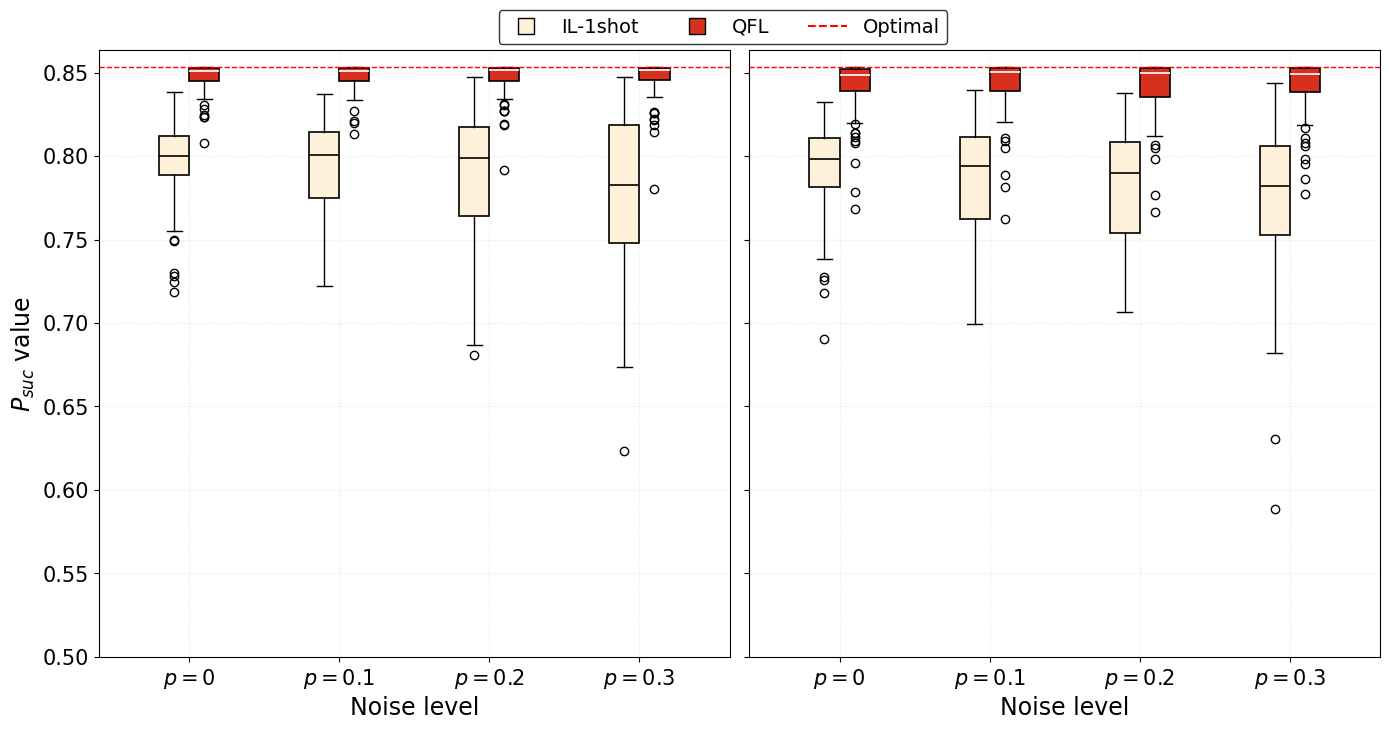

In [424]:
import matplotlib.pyplot as plt

# =====================================================
#  σ = 0.5 data
# =====================================================
Psucs_1s_0_s0  = all_mean_Psucs_1s_s05_setup2_noise00.flatten()
Psucs_1s_01_s0 = all_mean_Psucs_1s_s05_setup2_noise01.flatten()
Psucs_1s_02_s0 = all_mean_Psucs_1s_s05_setup2_noise02.flatten()
Psucs_1s_03_s0 = all_mean_Psucs_1s_s05_setup2_noise03.flatten()

Psucs_QFL_0_s0  = QFL_Psucs_s05_5_5_setup2_noise00.flatten()
Psucs_QFL_01_s0 = QFL_Psucs_s05_5_5_setup2_noise01.flatten()
Psucs_QFL_02_s0 = QFL_Psucs_s05_5_5_setup2_noise02.flatten()
Psucs_QFL_03_s0 = QFL_Psucs_s05_5_5_setup2_noise03.flatten()

data_1s_sigma0  = [Psucs_1s_0_s0, Psucs_1s_01_s0, Psucs_1s_02_s0, Psucs_1s_03_s0]
data_QFL_sigma0 = [Psucs_QFL_0_s0, Psucs_QFL_01_s0, Psucs_QFL_02_s0, Psucs_QFL_03_s0]

# =====================================================
#  σ = 1.0 data
# =====================================================
Psucs_1s_0_s4  = all_mean_Psucs_1s_s1_setup2_noise00.flatten()
Psucs_1s_01_s4 = all_mean_Psucs_1s_s1_setup2_noise01.flatten()
Psucs_1s_02_s4 = all_mean_Psucs_1s_s1_setup2_noise02.flatten()
Psucs_1s_03_s4 = all_mean_Psucs_1s_s1_setup2_noise03.flatten()

Psucs_QFL_0_s4  = QFL_Psucs_s1_5_5_setup2_noise00.flatten()
Psucs_QFL_01_s4 = QFL_Psucs_s1_5_5_setup2_noise01.flatten()
Psucs_QFL_02_s4 = QFL_Psucs_s1_5_5_setup2_noise02.flatten()
Psucs_QFL_03_s4 = QFL_Psucs_s1_5_5_setup2_noise03.flatten()

data_1s_sigma4  = [Psucs_1s_0_s4, Psucs_1s_01_s4, Psucs_1s_02_s4, Psucs_1s_03_s4]
data_QFL_sigma4 = [Psucs_QFL_0_s4, Psucs_QFL_01_s4, Psucs_QFL_02_s4, Psucs_QFL_03_s4]

# =====================================================
#  Shared settings
# =====================================================
color_1s  = "#fef0d9"
color_qfl = "#d7301f"
edge_color = "black"

noise_labels = ["$p=0$", "$p=0.1$", "$p=0.2$", "$p=0.3$"]
group_centers = list(range(1, len(noise_labels) + 1))
width = 0.2
offsets = [-width/2, width/2]
positions_1s  = [c + offsets[0] for c in group_centers]
positions_QFL = [c + offsets[1] for c in group_centers]

# =====================================================
#  Larger & taller figure with bigger tick labels
# =====================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# fontsize settings
title_fs = 17
label_fs = 17
tick_fs = 15
legend_fs = 14

# ----------------------------------------
# Function to plot one panel
# ----------------------------------------
def plot_panel(ax, data_1s, data_QFL, title):
    # SC-1shot
    for pos, data in zip(positions_1s, data_1s):
        ax.boxplot(
            data, positions=[pos], widths=width, patch_artist=True,
            boxprops=dict(facecolor=color_1s, color=edge_color, linewidth=1.2),
            medianprops=dict(color='black', linewidth=1.2)
        )

    # QFL
    for pos, data in zip(positions_QFL, data_QFL):
        ax.boxplot(
            data, positions=[pos], widths=width, patch_artist=True,
            boxprops=dict(facecolor=color_qfl, color=edge_color, linewidth=1.2),
            medianprops=dict(color='white', linewidth=1.2)
        )

    # Reference line
    ax.axhline(0.8536, color='red', linestyle='--', linewidth=1)

    # Axis formatting
    ax.set_xticks(group_centers)
    ax.set_xticklabels(noise_labels)
    ax.set_title(title, fontsize=title_fs)
    ax.set_xlabel("Noise level", fontsize=label_fs)
    ax.set_ylim(0.50, 0.8636)

    ax.tick_params(axis='x', labelsize=tick_fs)
    ax.tick_params(axis='y', labelsize=tick_fs)

    # Grid
    ax.grid(True, linestyle=':', alpha=0.3)

# ----------------------------------------
# Left: σ = 0.0
# ----------------------------------------
plot_panel(axes[0], data_1s_sigma0, data_QFL_sigma0,
           r"")
axes[0].set_ylabel("$P_{suc}$ value", fontsize=label_fs)

# ----------------------------------------
# Right: σ = 4.0
# ----------------------------------------
plot_panel(axes[1], data_1s_sigma4, data_QFL_sigma4,
           r"")

# ----------------------------------------
# Centered legend in a thin box **inside** the figure
# ----------------------------------------
handles = [
    plt.Line2D([], [], color=edge_color, marker='s', markerfacecolor=color_1s,
               markersize=12, linestyle='None', label='IL-1shot'),
    plt.Line2D([], [], color=edge_color, marker='s', markerfacecolor=color_qfl,
               markersize=12, linestyle='None', label='QFL'),
    plt.Line2D([], [], color='red', linestyle='--', label='Optimal'),
]

fig.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.52, 1.05),
    ncol=3,
    fontsize=legend_fs,
    frameon=True,
    facecolor='white',
    edgecolor='black',
    framealpha=0.8
)

plt.tight_layout()
plt.savefig("noise_comparison_setup2_s05_s1.png", dpi=600, bbox_inches="tight")
plt.show()

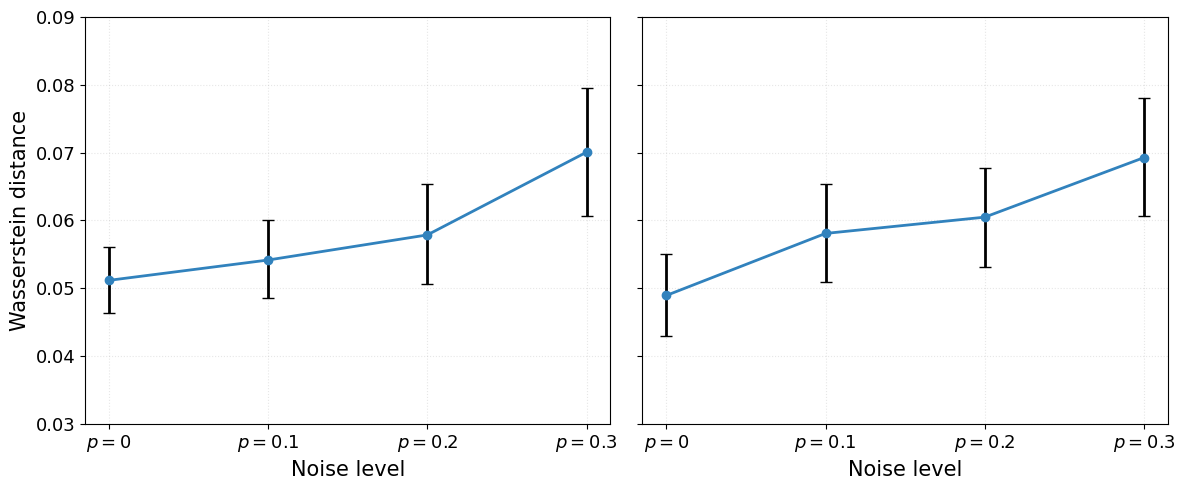

In [428]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# ======================
# 1) PREPARE DATA
# ======================

# ---- σ = 0.5 ----
SC_s0 = [
    all_mean_Psucs_1s_s05_setup2_noise00.flatten(),
    all_mean_Psucs_1s_s05_setup2_noise01.flatten(),
    all_mean_Psucs_1s_s05_setup2_noise02.flatten(),
    all_mean_Psucs_1s_s05_setup2_noise03.flatten()
]

QFL_s0 = [
    QFL_Psucs_s05_5_5_setup2_noise00.flatten(),
    QFL_Psucs_s05_5_5_setup2_noise01.flatten(),
    QFL_Psucs_s05_5_5_setup2_noise02.flatten(),
    QFL_Psucs_s05_5_5_setup2_noise03.flatten()
]

# ---- σ = 1 ----
SC_s4 = [
    all_mean_Psucs_1s_s1_setup2_noise00.flatten(),
    all_mean_Psucs_1s_s1_setup2_noise01.flatten(),
    all_mean_Psucs_1s_s1_setup2_noise02.flatten(),
    all_mean_Psucs_1s_s1_setup2_noise03.flatten()
]

QFL_s4 = [
    QFL_Psucs_s1_5_5_setup2_noise00.flatten(),
    QFL_Psucs_s1_5_5_setup2_noise01.flatten(),
    QFL_Psucs_s1_5_5_setup2_noise02.flatten(),
    QFL_Psucs_s1_5_5_setup2_noise03.flatten()
]

noise_levels = np.array([0.0, 0.1, 0.2, 0.3])


# ======================
# 2) FUNCTION: BOOTSTRAP CI
# ======================

def bootstrap_wasserstein(a, b, B=2000, ci=0.95):
    """Returns (mean, lower_CI, upper_CI) for Wasserstein distance."""
    nA, nB = len(a), len(b)
    boot_values = np.zeros(B)

    for i in range(B):
        a_s = np.random.choice(a, size=nA, replace=True)
        b_s = np.random.choice(b, size=nB, replace=True)
        boot_values[i] = wasserstein_distance(a_s, b_s)

    mean = np.mean(boot_values)
    lower = np.percentile(boot_values, (1 - ci) / 2 * 100)
    upper = np.percentile(boot_values, (1 + ci) / 2 * 100)

    return mean, lower, upper


# ======================
# 3) COMPUTE DISTANCES + CI FOR σ=0 and σ=4
# ======================

def compute_all_wasserstein(SC_list, QFL_list):
    means, lowers, uppers = [], [], []
    for sc, qfl in zip(SC_list, QFL_list):
        m, lo, up = bootstrap_wasserstein(sc, qfl)
        means.append(m)
        lowers.append(lo)
        uppers.append(up)
    return np.array(means), np.array(lowers), np.array(uppers)

mean0, low0, up0 = compute_all_wasserstein(SC_s0, QFL_s0)
mean4, low4, up4 = compute_all_wasserstein(SC_s4, QFL_s4)

# Error bars
err_low_0 = mean0 - low0
err_up_0 = up0 - mean0
err_low_4 = mean4 - low4
err_up_4 = up4 - mean4


# ======================
# 4) PLOT — TWO SUBPLOTS SIDE BY SIDE
# ======================

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Colors
color_line = "#3182bd"

# Common y-limits
# ymin, ymax = 0.11, 0.19
ymin, ymax = 0.03, 0.09

# --- σ = 0 subplot ---
axes[0].errorbar(
    noise_levels, mean0,
    yerr=[err_low_0, err_up_0],
    fmt='o-', color=color_line, markersize=6,
    ecolor="black", capsize=4, linewidth=2
)
# axes[0].set_title(r"$\sigma = 0$")
axes[0].set_xlabel("Noise level", fontsize=15)
axes[0].set_ylabel("Wasserstein distance", fontsize=15)
axes[0].grid(True, linestyle=":", alpha=0.3)
xticks = noise_levels
xtick_labels = [r"$p=0$", r"$p=0.1$", r"$p=0.2$", r"$p=0.3$"]

axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xtick_labels)
axes[0].set_ylim(ymin, ymax)
axes[0].tick_params(axis='both', labelsize=13)

# --- σ = 4 subplot ---
axes[1].errorbar(
    noise_levels, mean4,
    yerr=[err_low_4, err_up_4],
    fmt='o-', color=color_line, markersize=6,
    ecolor="black", capsize=4, linewidth=2
)
# axes[1].set_title(r"$\sigma = 4$")
axes[1].set_xlabel("Noise level", fontsize=15)
axes[1].grid(True, linestyle=":", alpha=0.3)
xticks = noise_levels
xtick_labels = [r"$p=0$", r"$p=0.1$", r"$p=0.2$", r"$p=0.3$"]

axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xtick_labels)
axes[1].set_ylim(ymin, ymax)

# --- IMPORTANT FIX ---
axes[1].tick_params(axis='y', labelleft=False)   # hide numbers but keep ticks
axes[1].tick_params(axis='x', labelsize=13)

plt.tight_layout()
plt.savefig("noise_wasserstein_setup2_s05_s1.png", dpi=600, bbox_inches="tight")
plt.show()